In [80]:
import numpy as np
import hydra
from omegaconf import DictConfig
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Exploration des Données (EDA)

### - Importation du dataset et la visualition des premieres lignes

In [65]:
df = pd.read_csv('../data/data.csv')

In [66]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


### - Analyse des types de donnees

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [68]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [69]:
df['street'].value_counts()

street
2520 Mulberry Walk NE    4
2500 Mulberry Walk NE    3
11716 16th Ave NE        2
35229 SE Terrace St      2
13800 453rd Ave SE       2
                        ..
501 N 143rd St           1
14855 SE 10th Pl         1
759 Ilwaco Pl NE         1
5148 S Creston St        1
8519 28th Ave NW         1
Name: count, Length: 4525, dtype: int64

In [70]:
df['country'].value_counts()

country
USA    4600
Name: count, dtype: int64

### Detection des valeurs manquantes

In [71]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

## les valeurs aberrantes

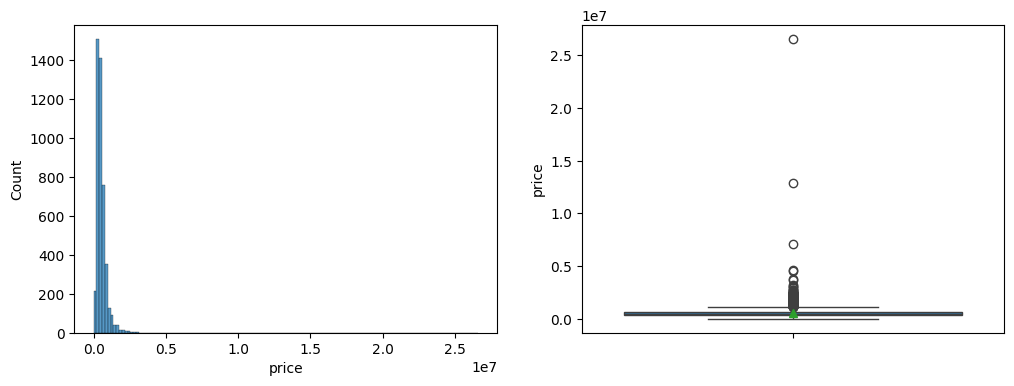

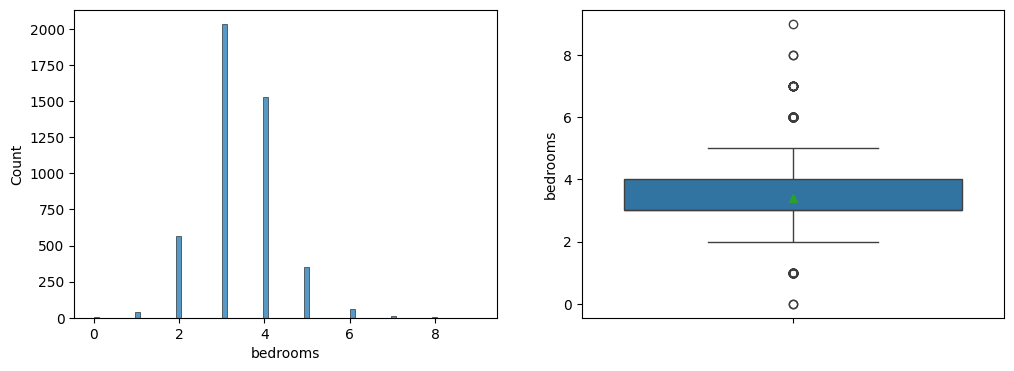

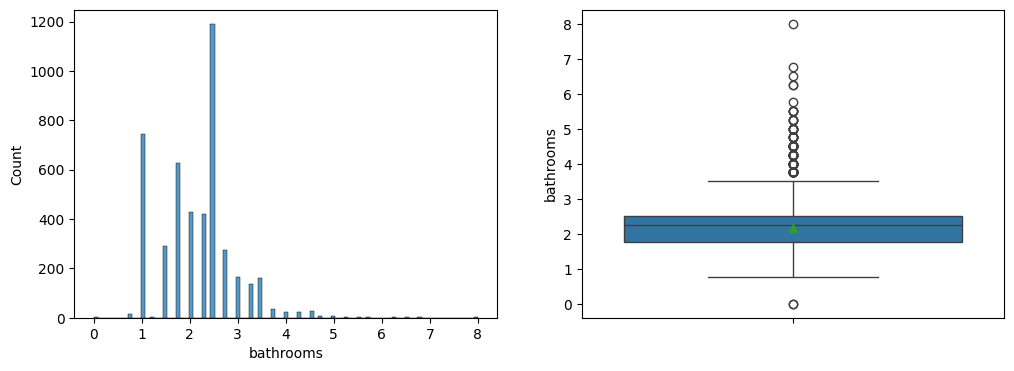

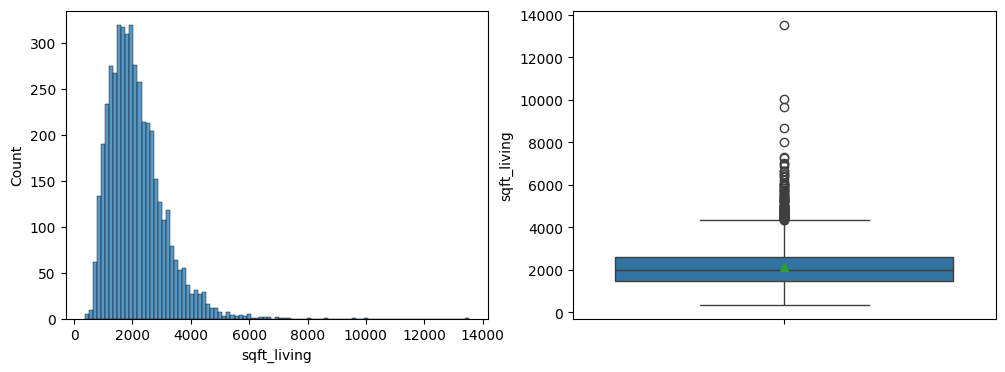

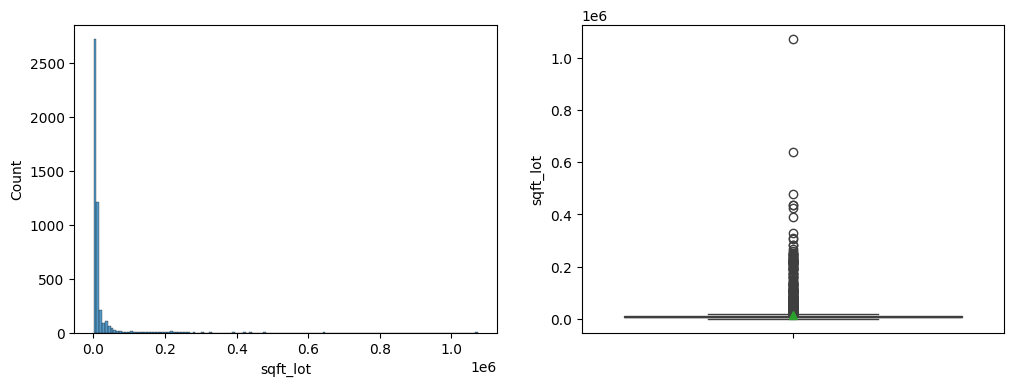

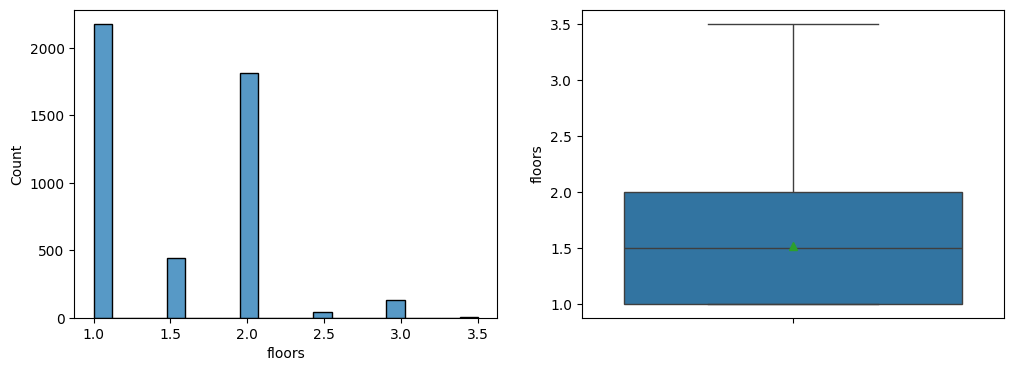

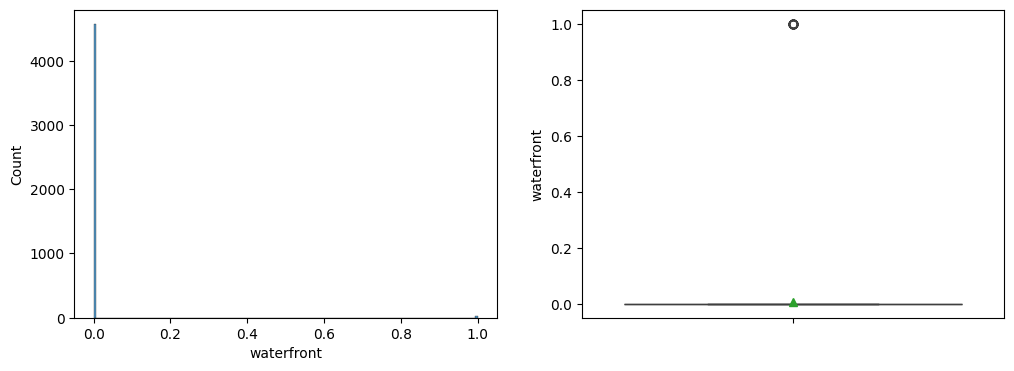

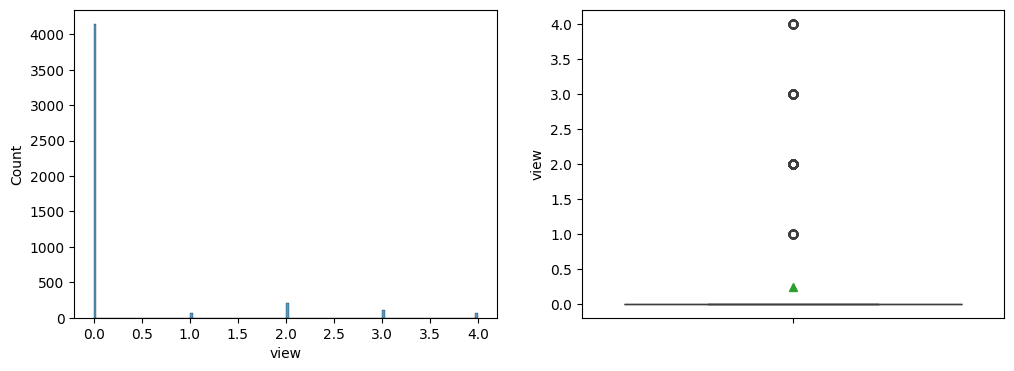

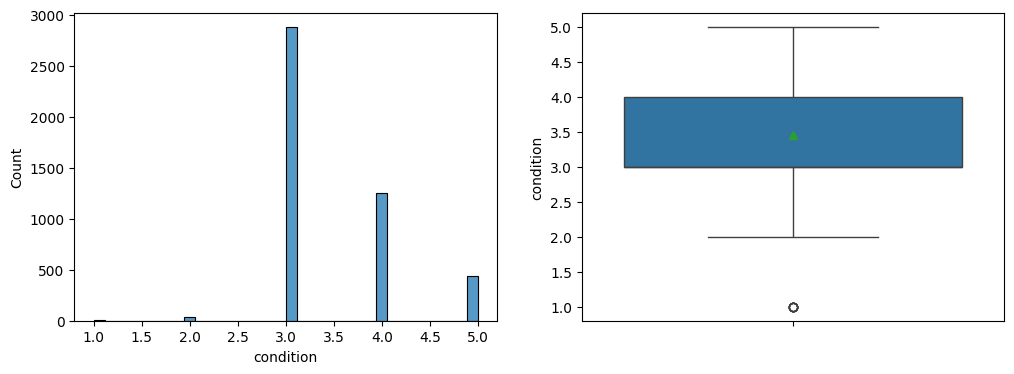

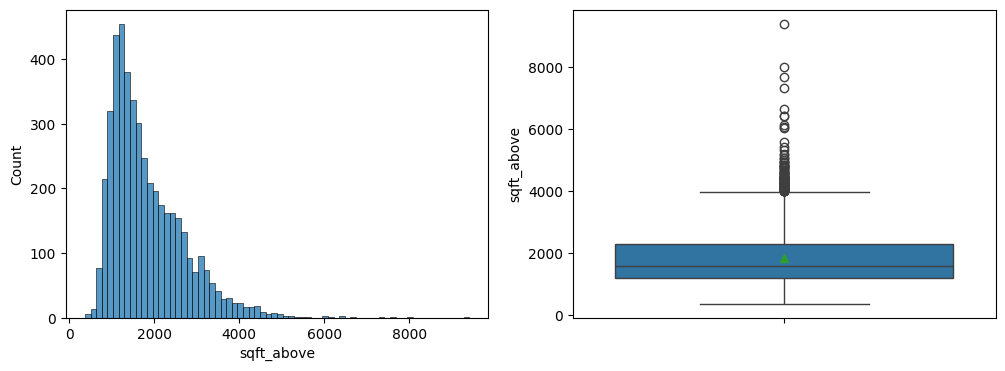

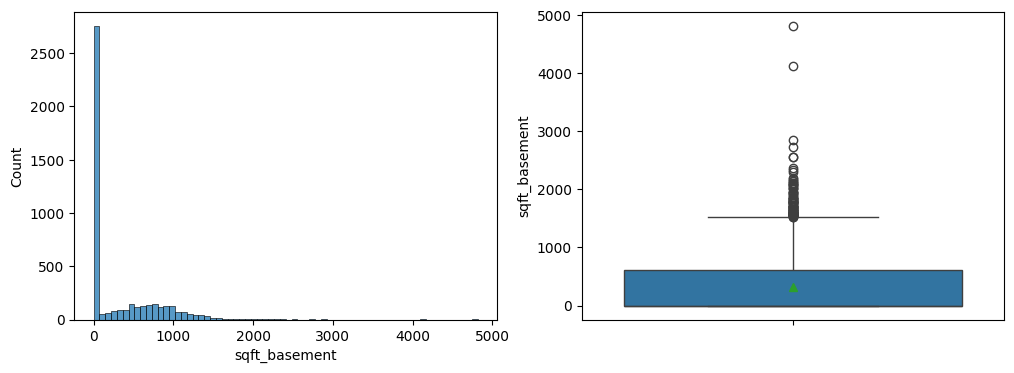

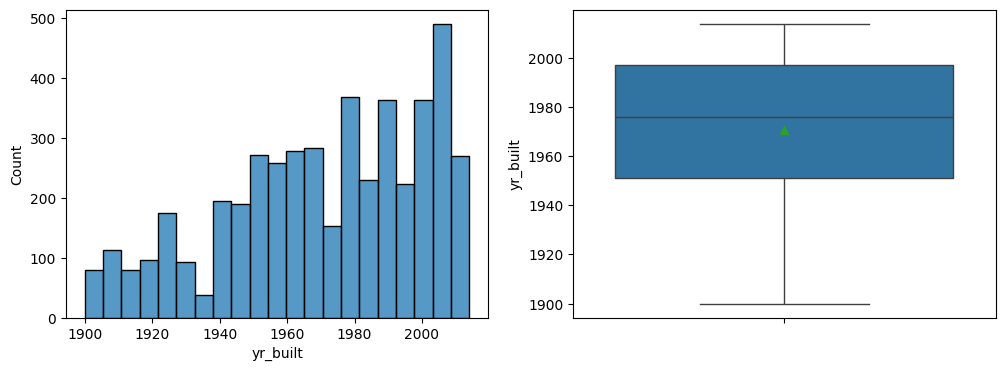

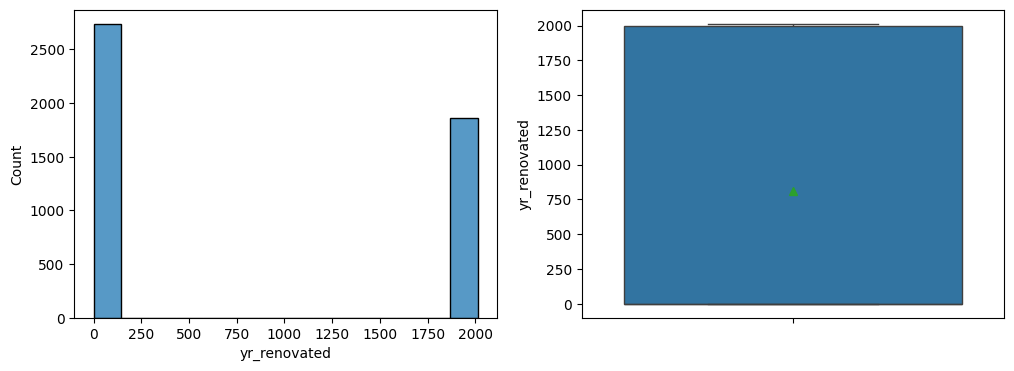

In [72]:
for col in df.select_dtypes('number').columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.histplot(df[col], ax = axes[0])
    sns.boxplot(df[col], ax = axes[1], showmeans=True)
plt.show() 

### Identificatoins des correlations 

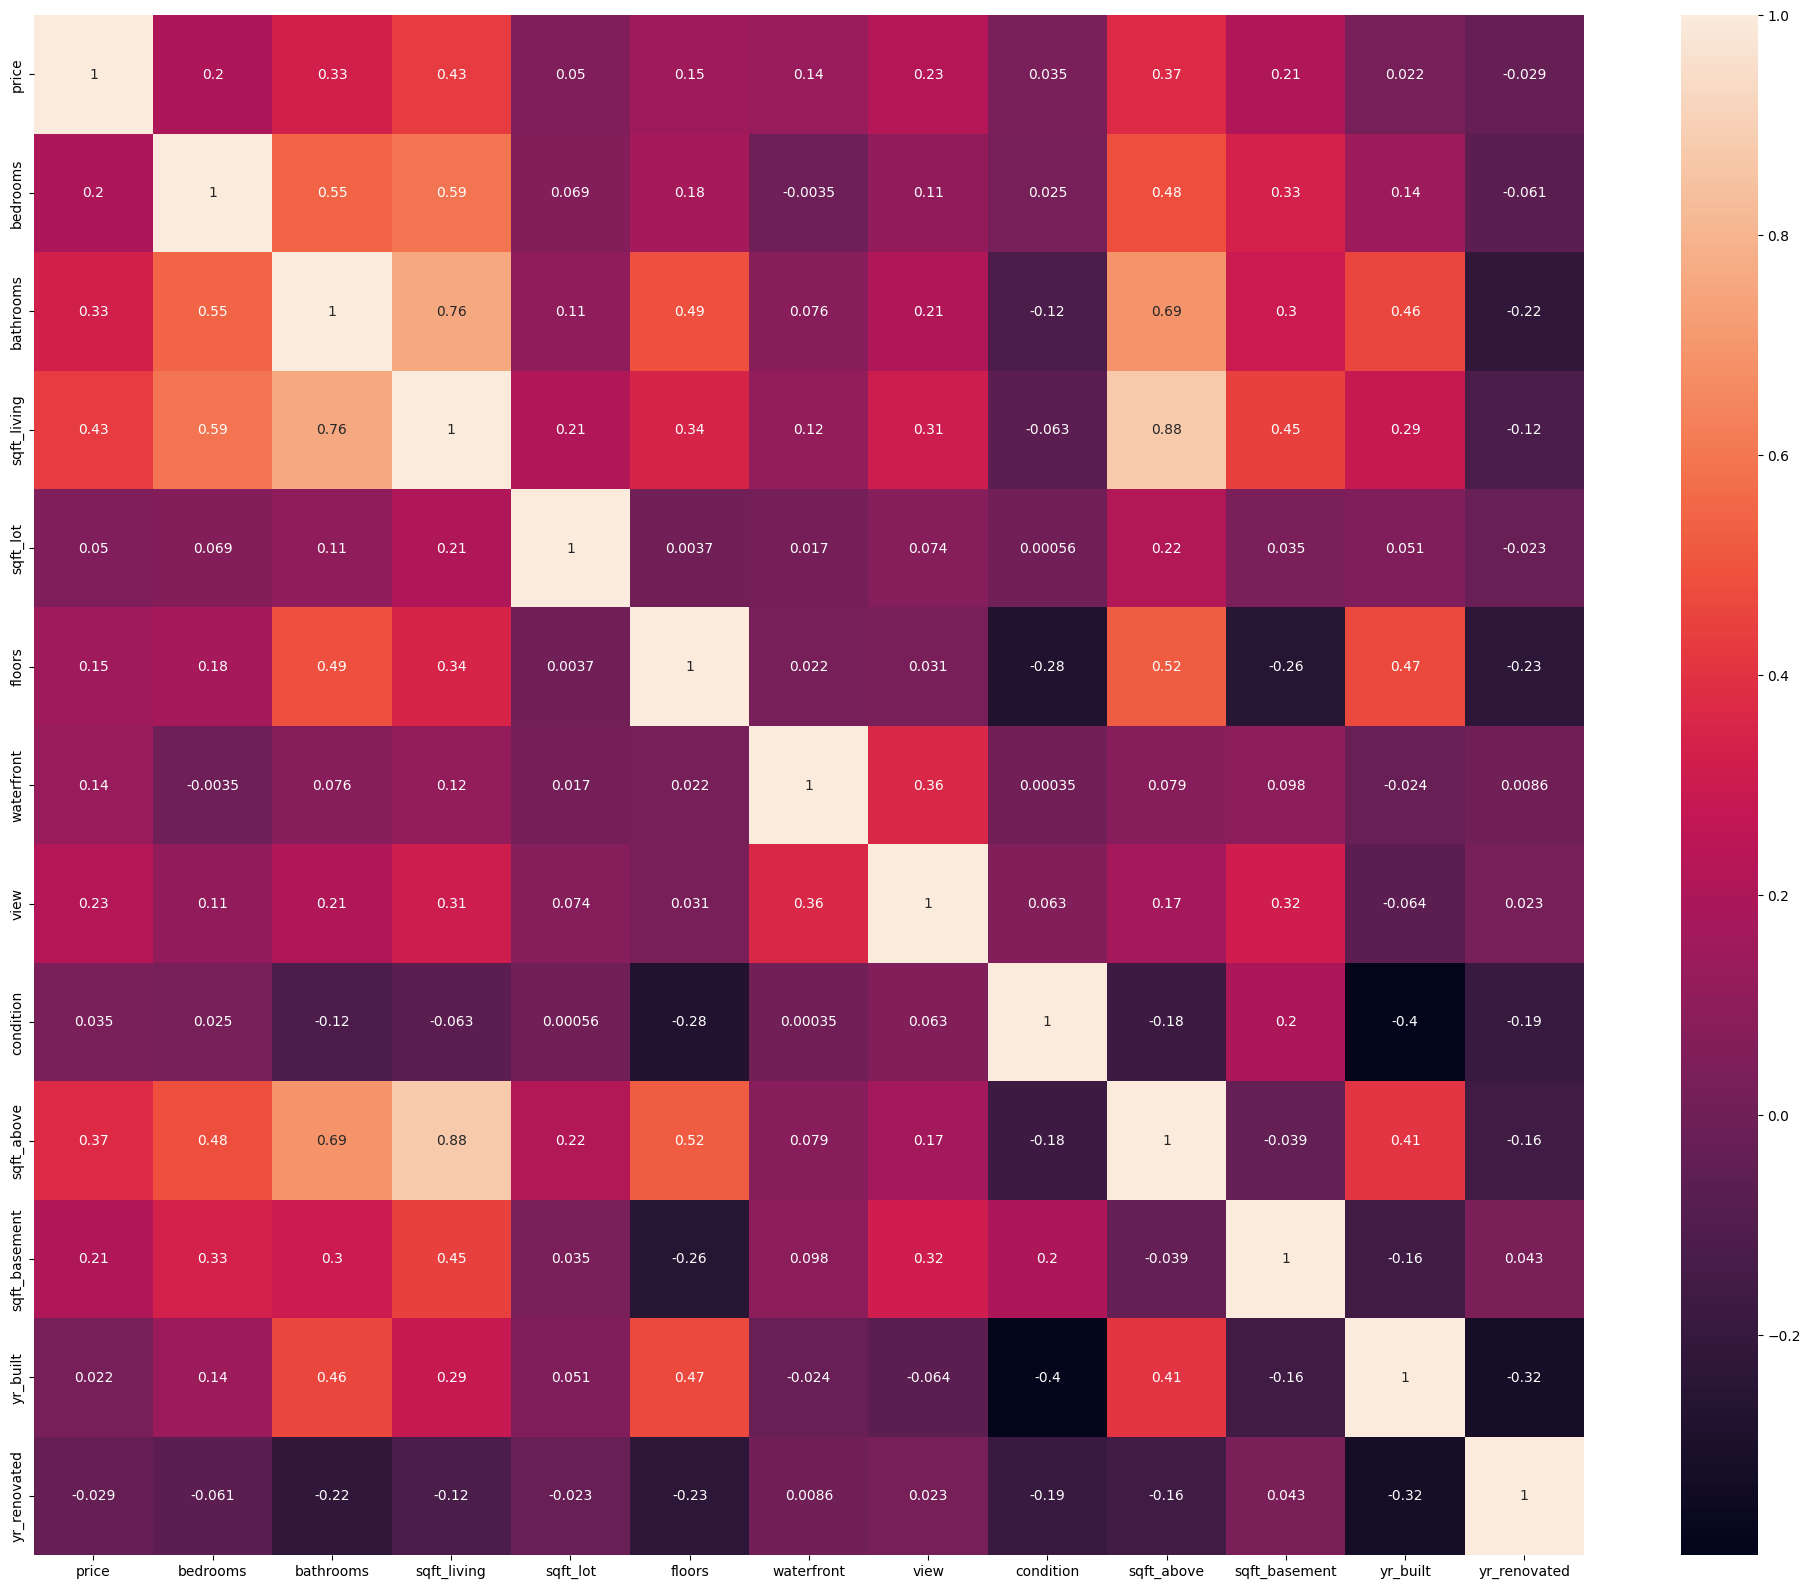

In [73]:
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(numeric_only=True), annot = True)
plt.show()

###  Visualiser la distribution des données pour les différentes classes(par exemple, satisfaction/non satisfaction)

<Axes: xlabel='price', ylabel='Count'>

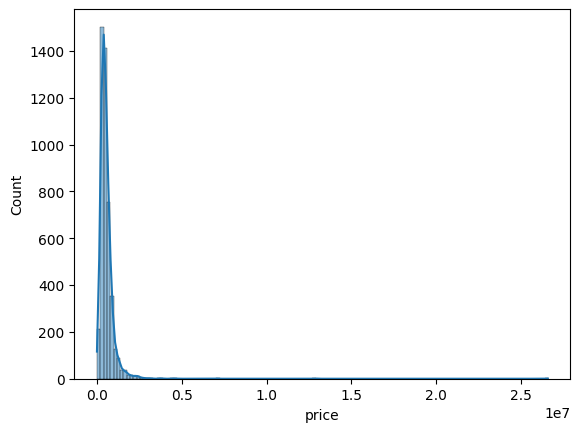

In [74]:
sns.histplot(df['price'], kde=True)

### 2. Prétraitement des Données

Dans ce cas de preprocessing, nous allons utiliser les pipelines, mais avant cela traitons d'abord les valeurs aberrantes

In [75]:
def impute_outliers(data, colname): 
    q1 = np.percentile(data[colname], 25)
    q3 = np.percentile(data[colname], 75) 

    lower_bound = q1 - 1.5*(q3 - q1)
    upper_bound = q3 + 1.5*(q3 - q1)

    data.loc[(data[colname] <= lower_bound), colname] = lower_bound
    data.loc[(data[colname] >= upper_bound), colname] = upper_bound

In [76]:
for colname in df.select_dtypes('number').columns:
    impute_outliers(df, colname)

C:\Users\ariel\AppData\Local\Temp\ipykernel_20876\843233136.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data[colname] <= lower_bound), colname] = lower_bound
C:\Users\ariel\AppData\Local\Temp\ipykernel_20876\843233136.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2998.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data[colname] <= lower_bound), colname] = lower_bound


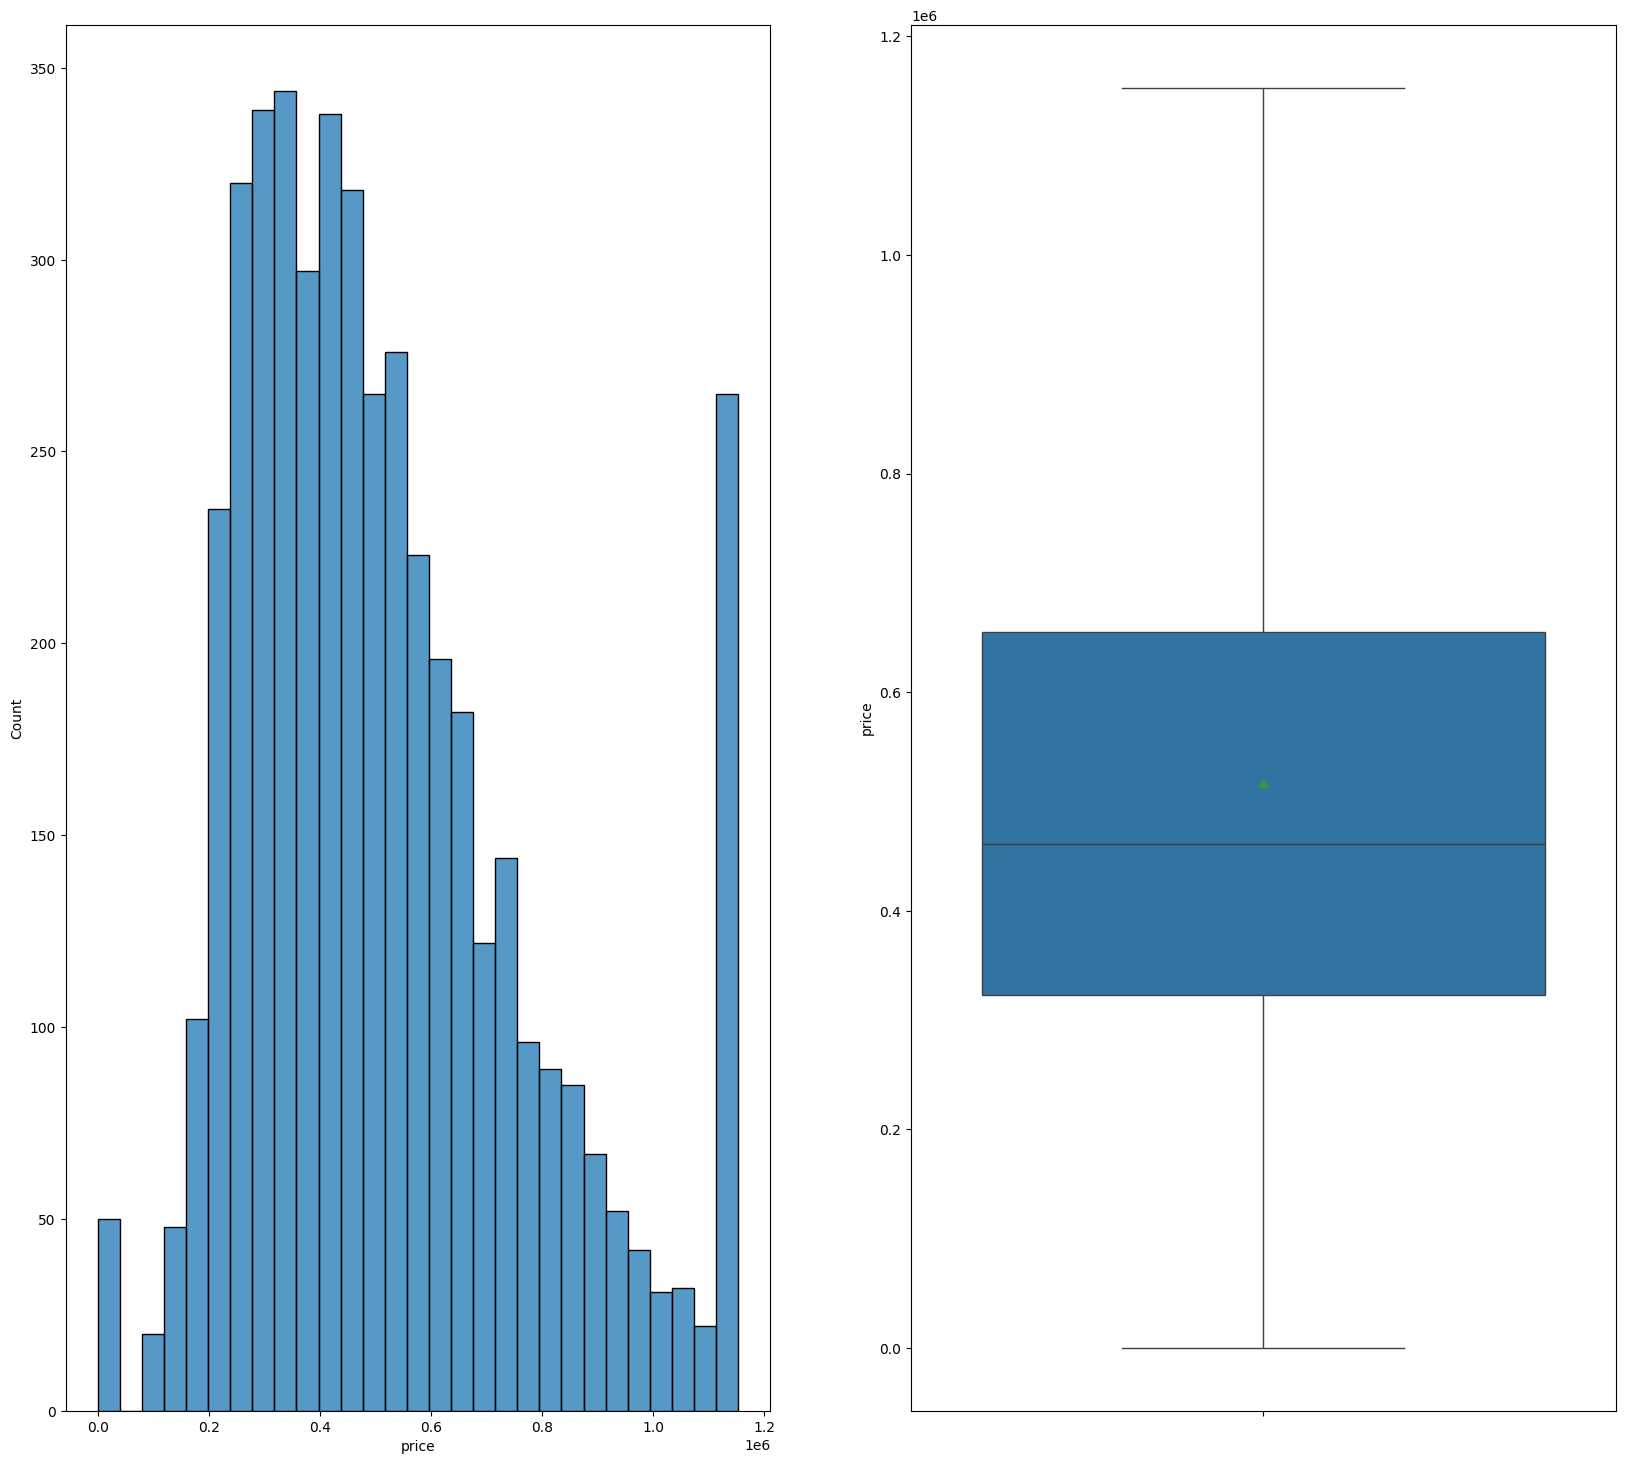

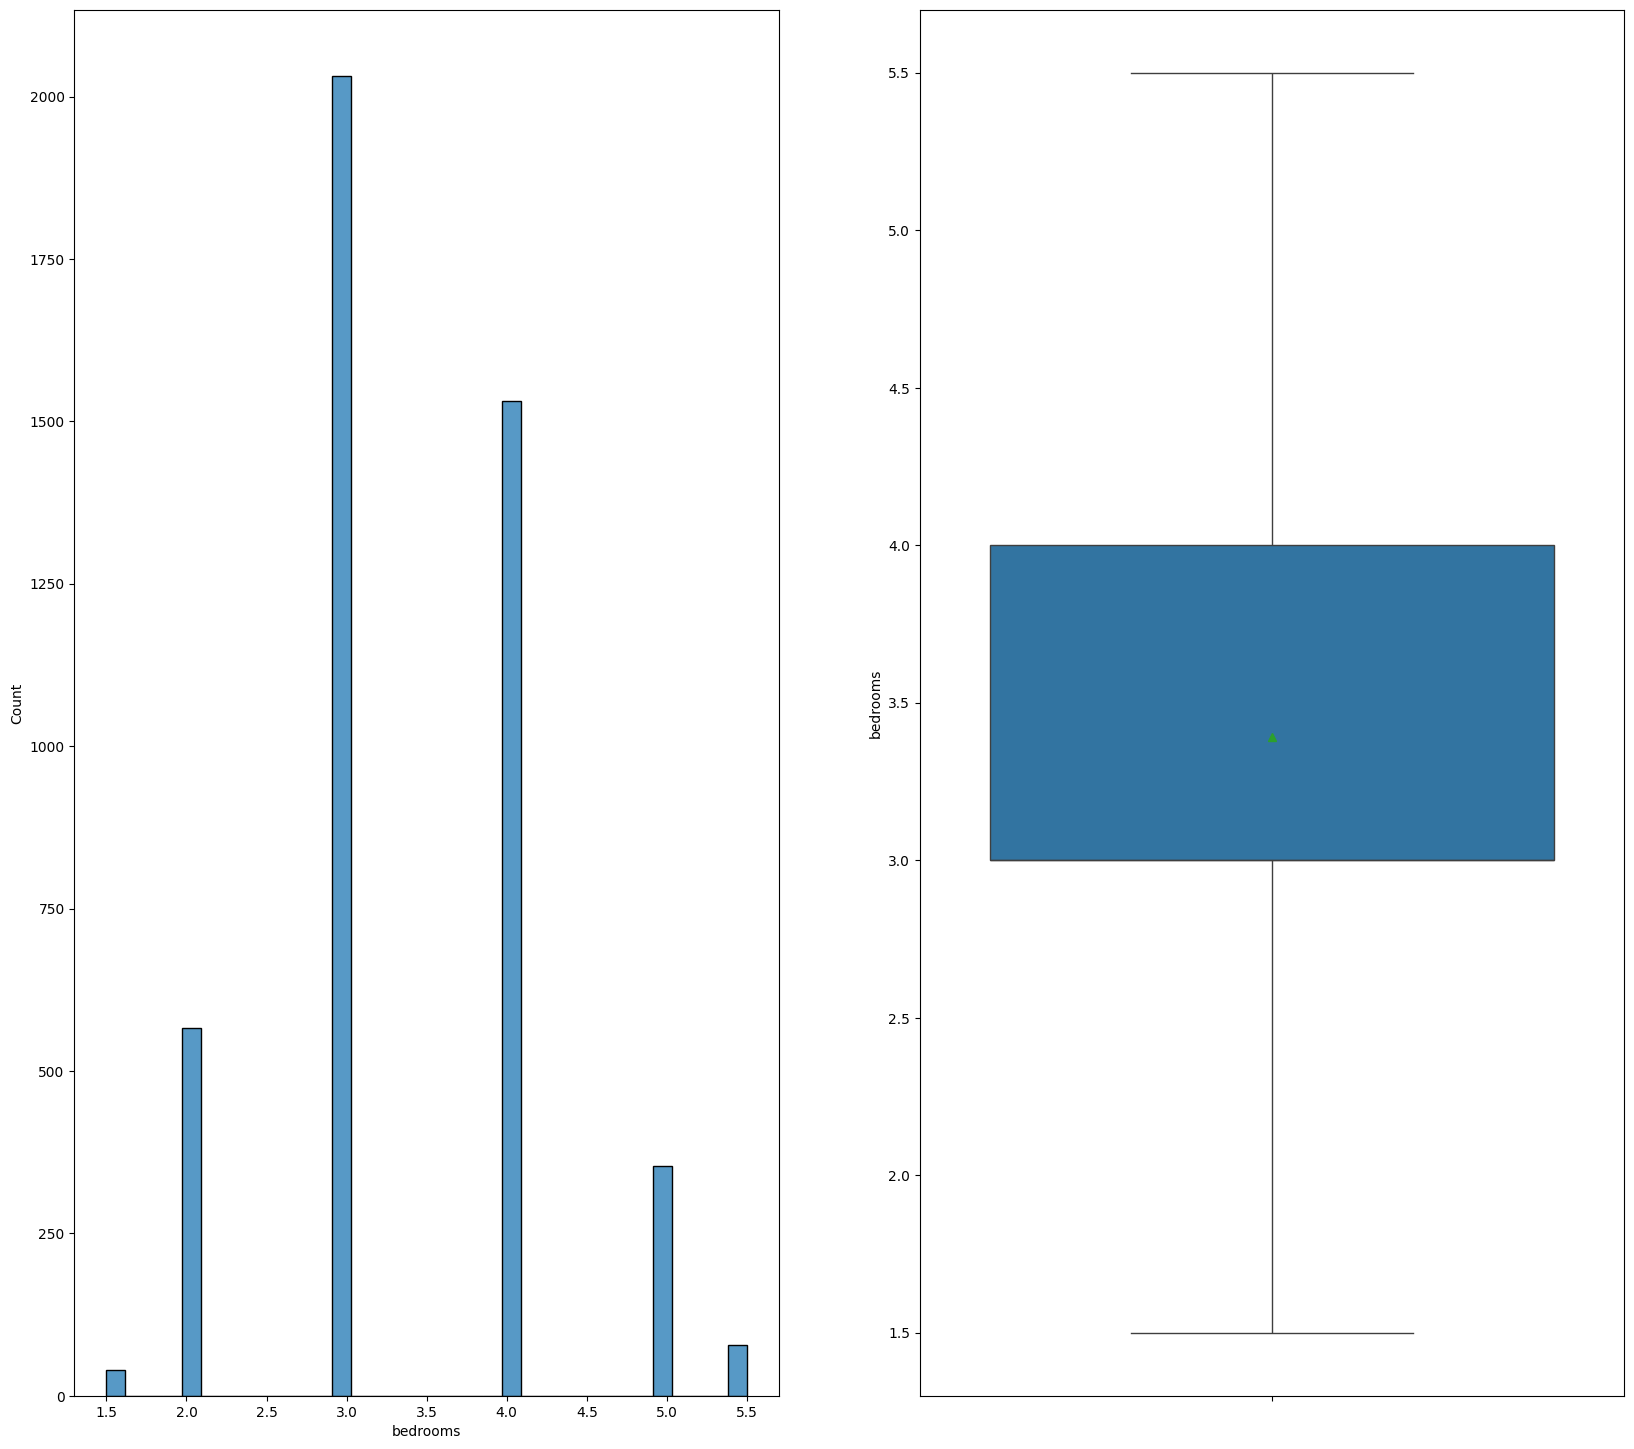

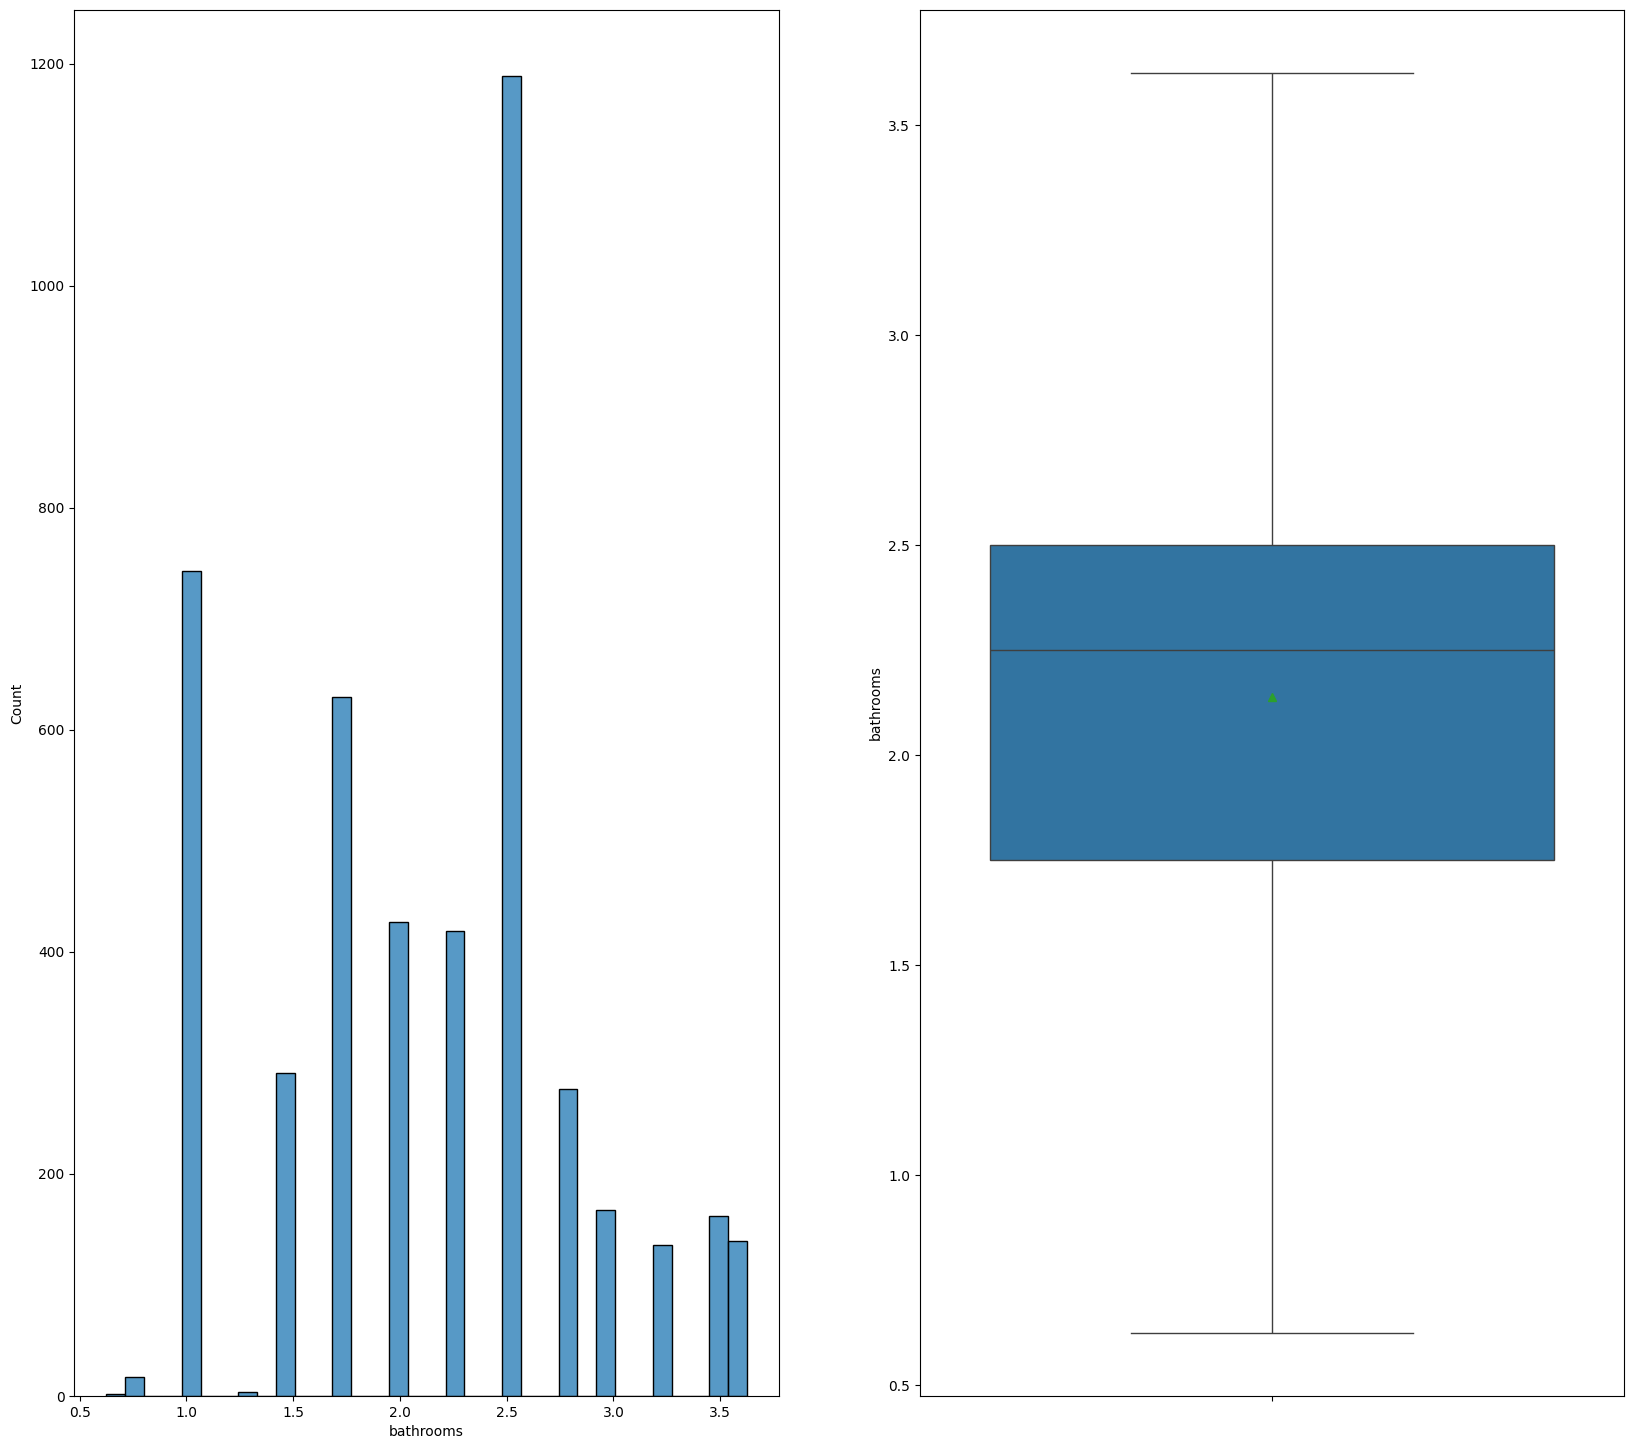

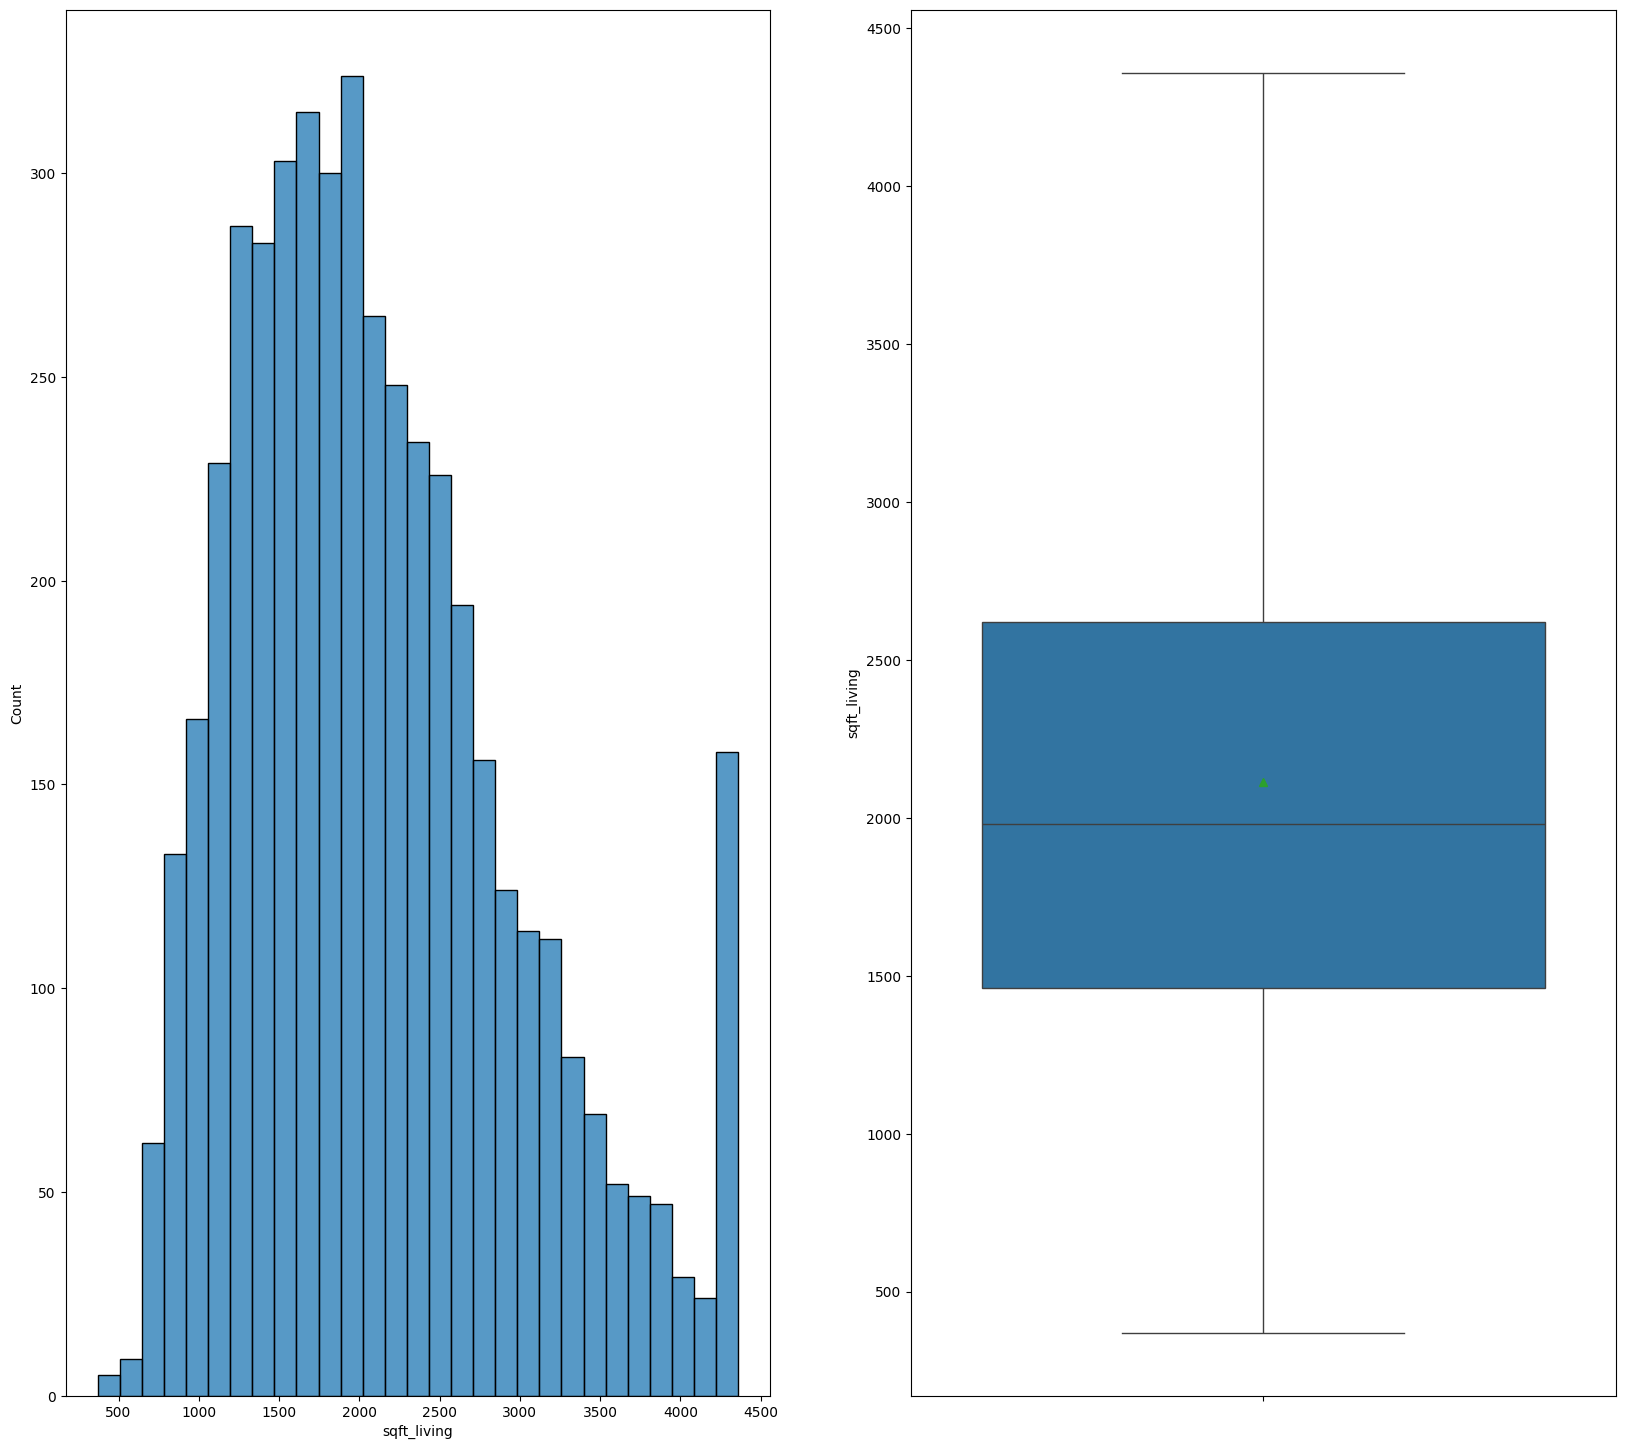

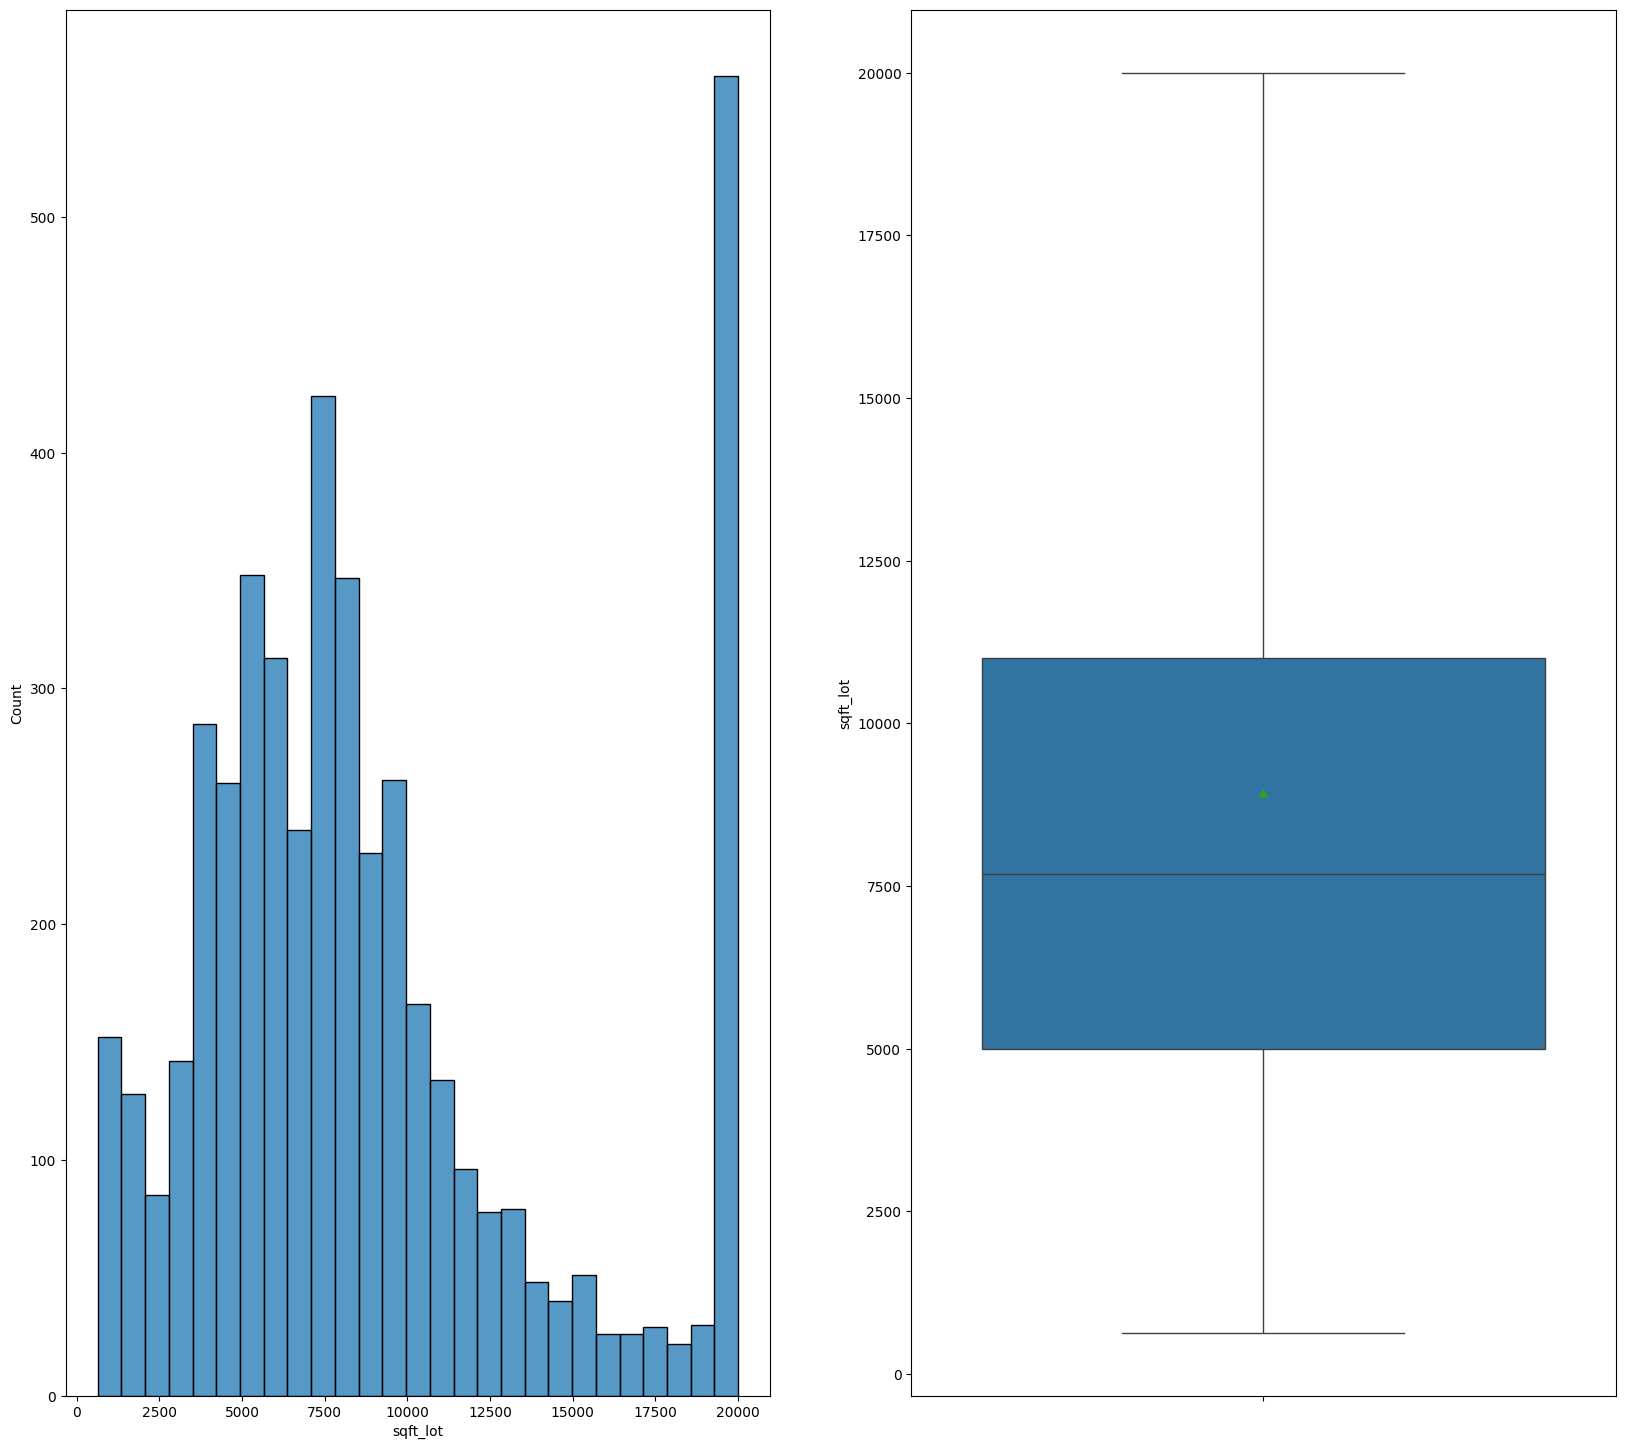

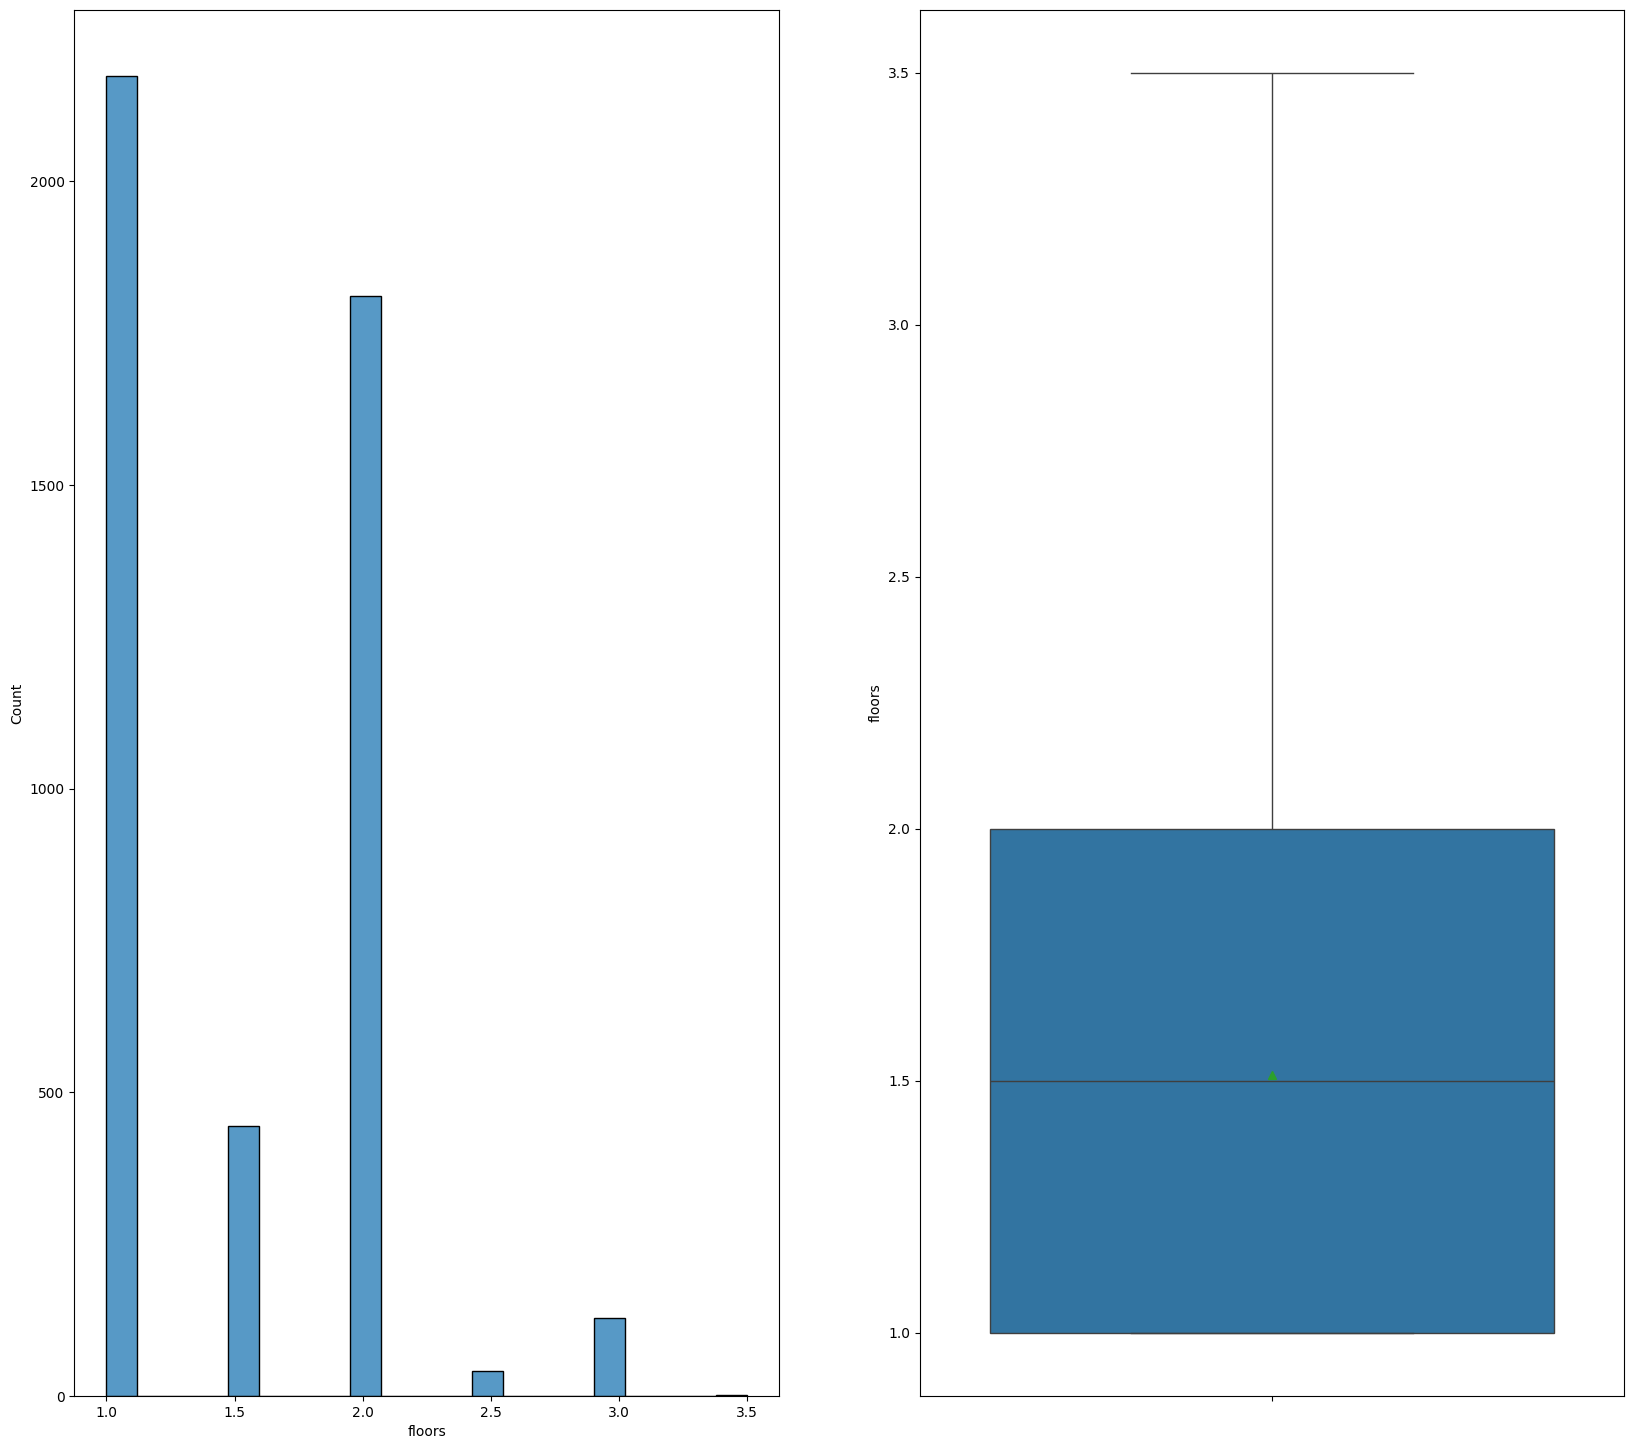

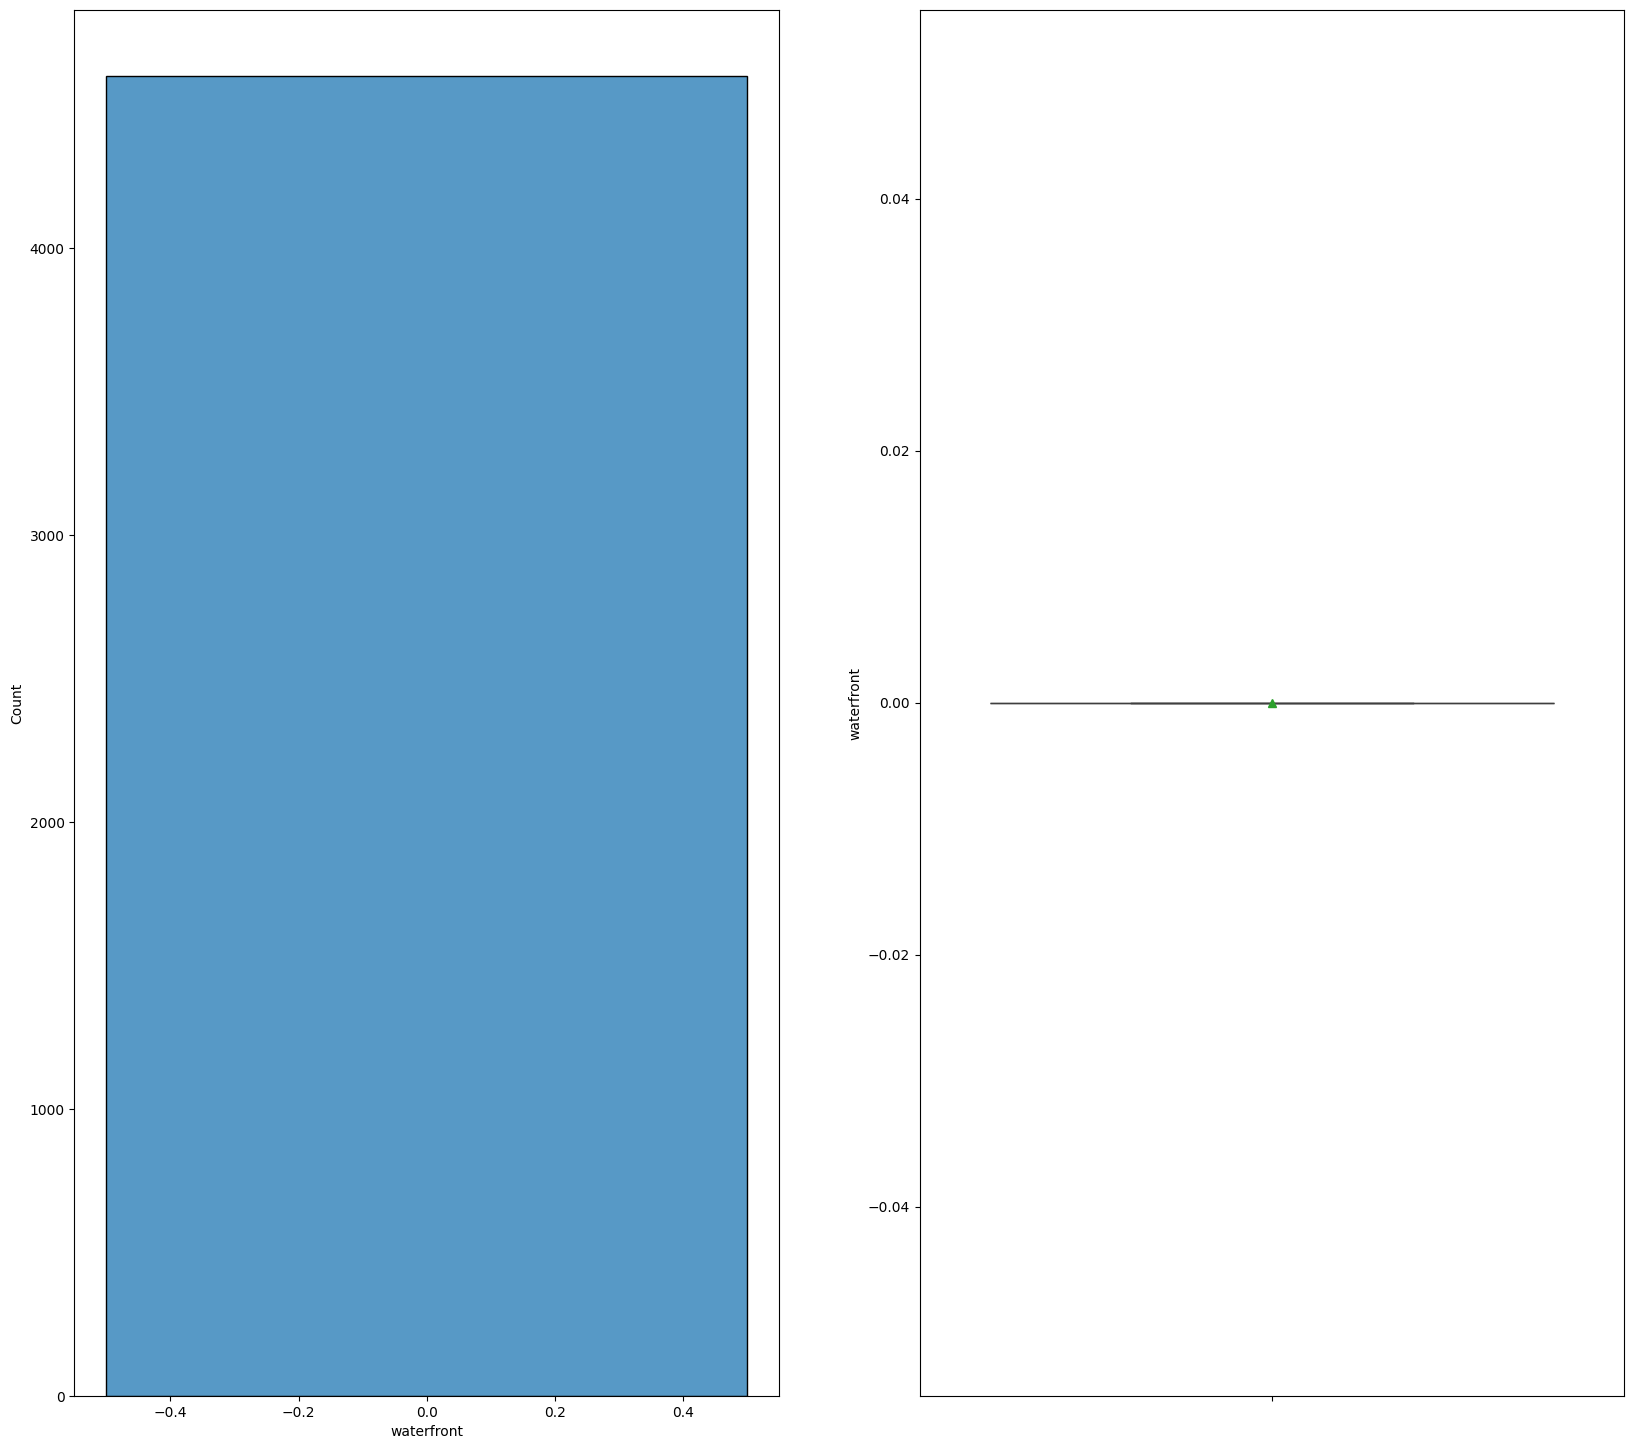

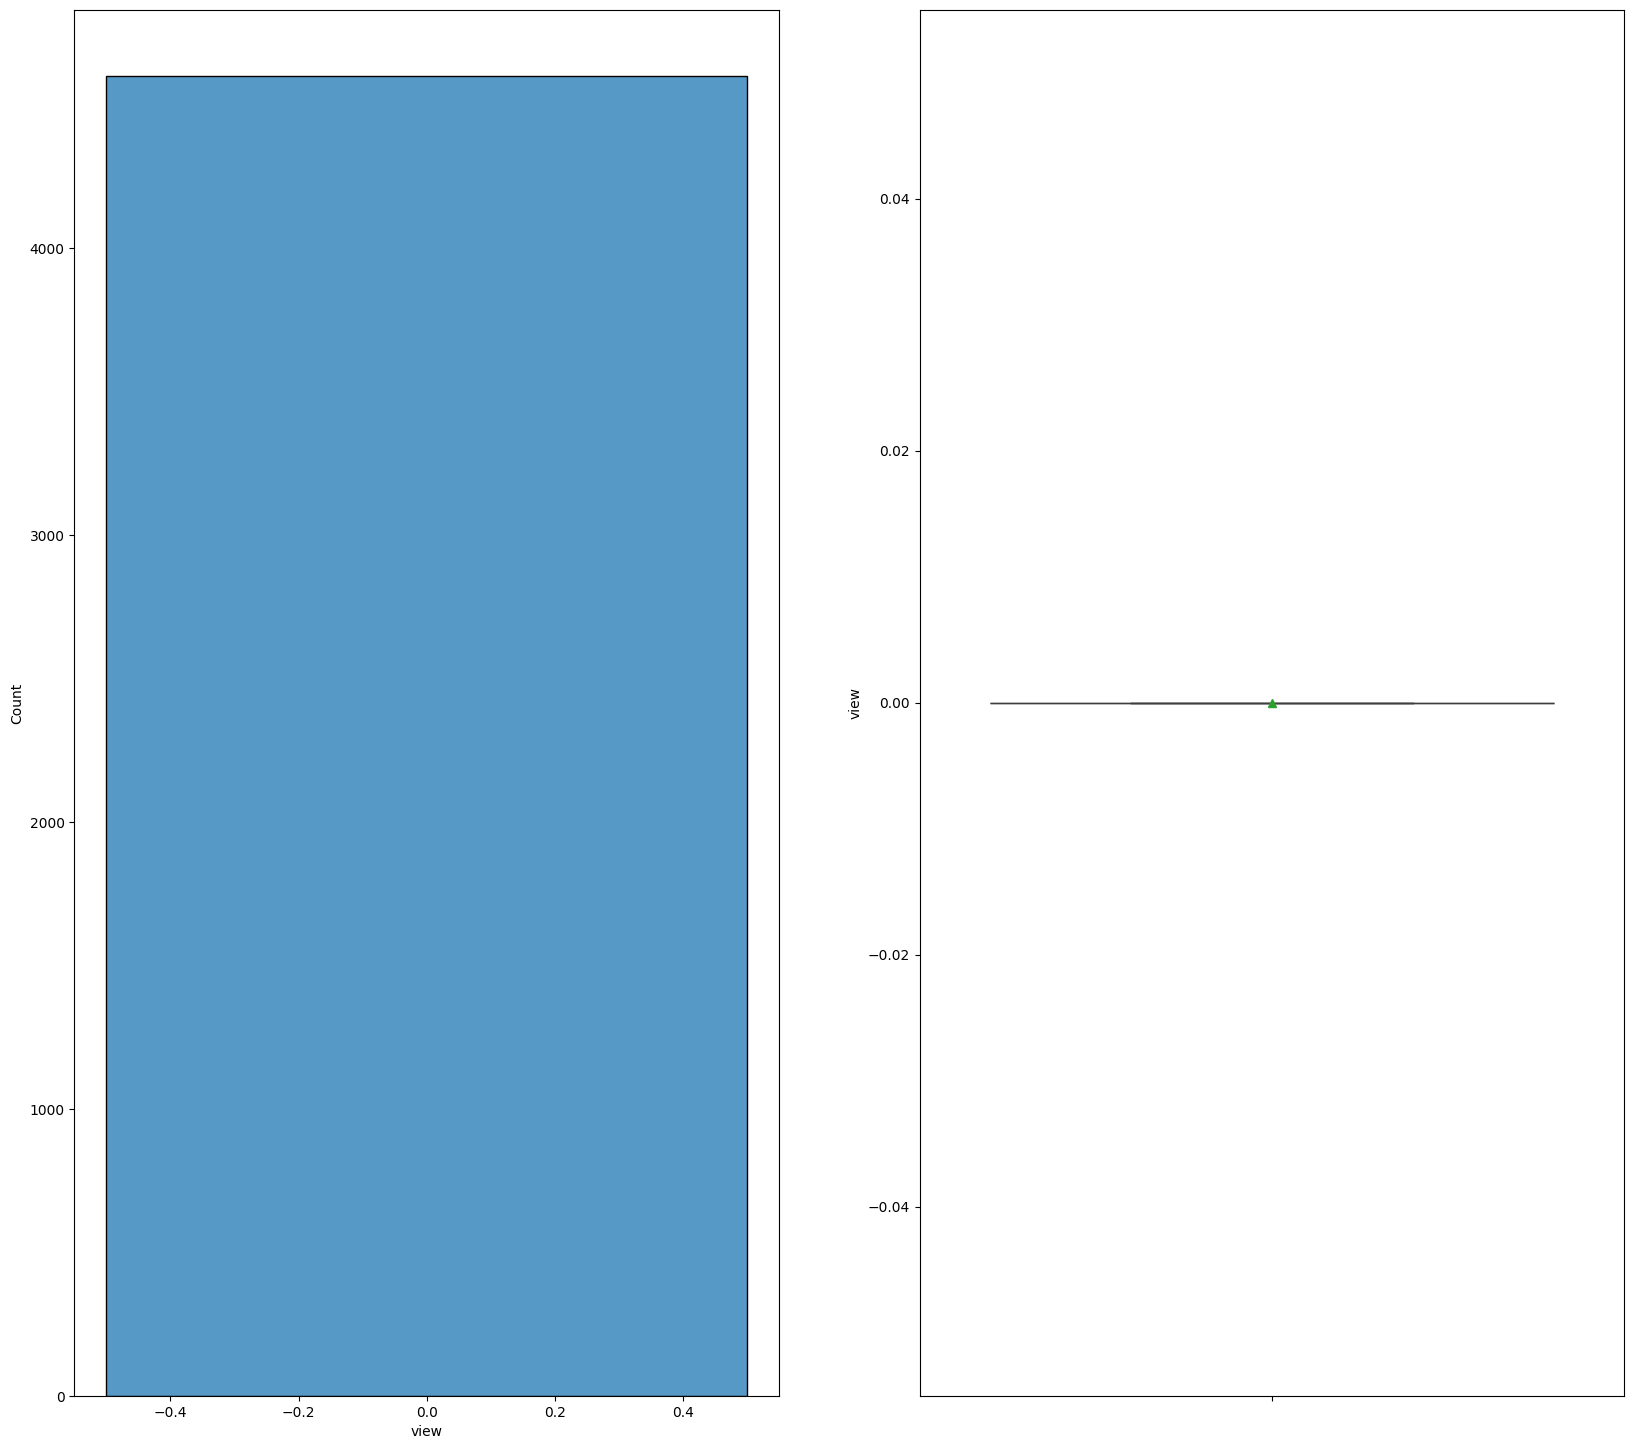

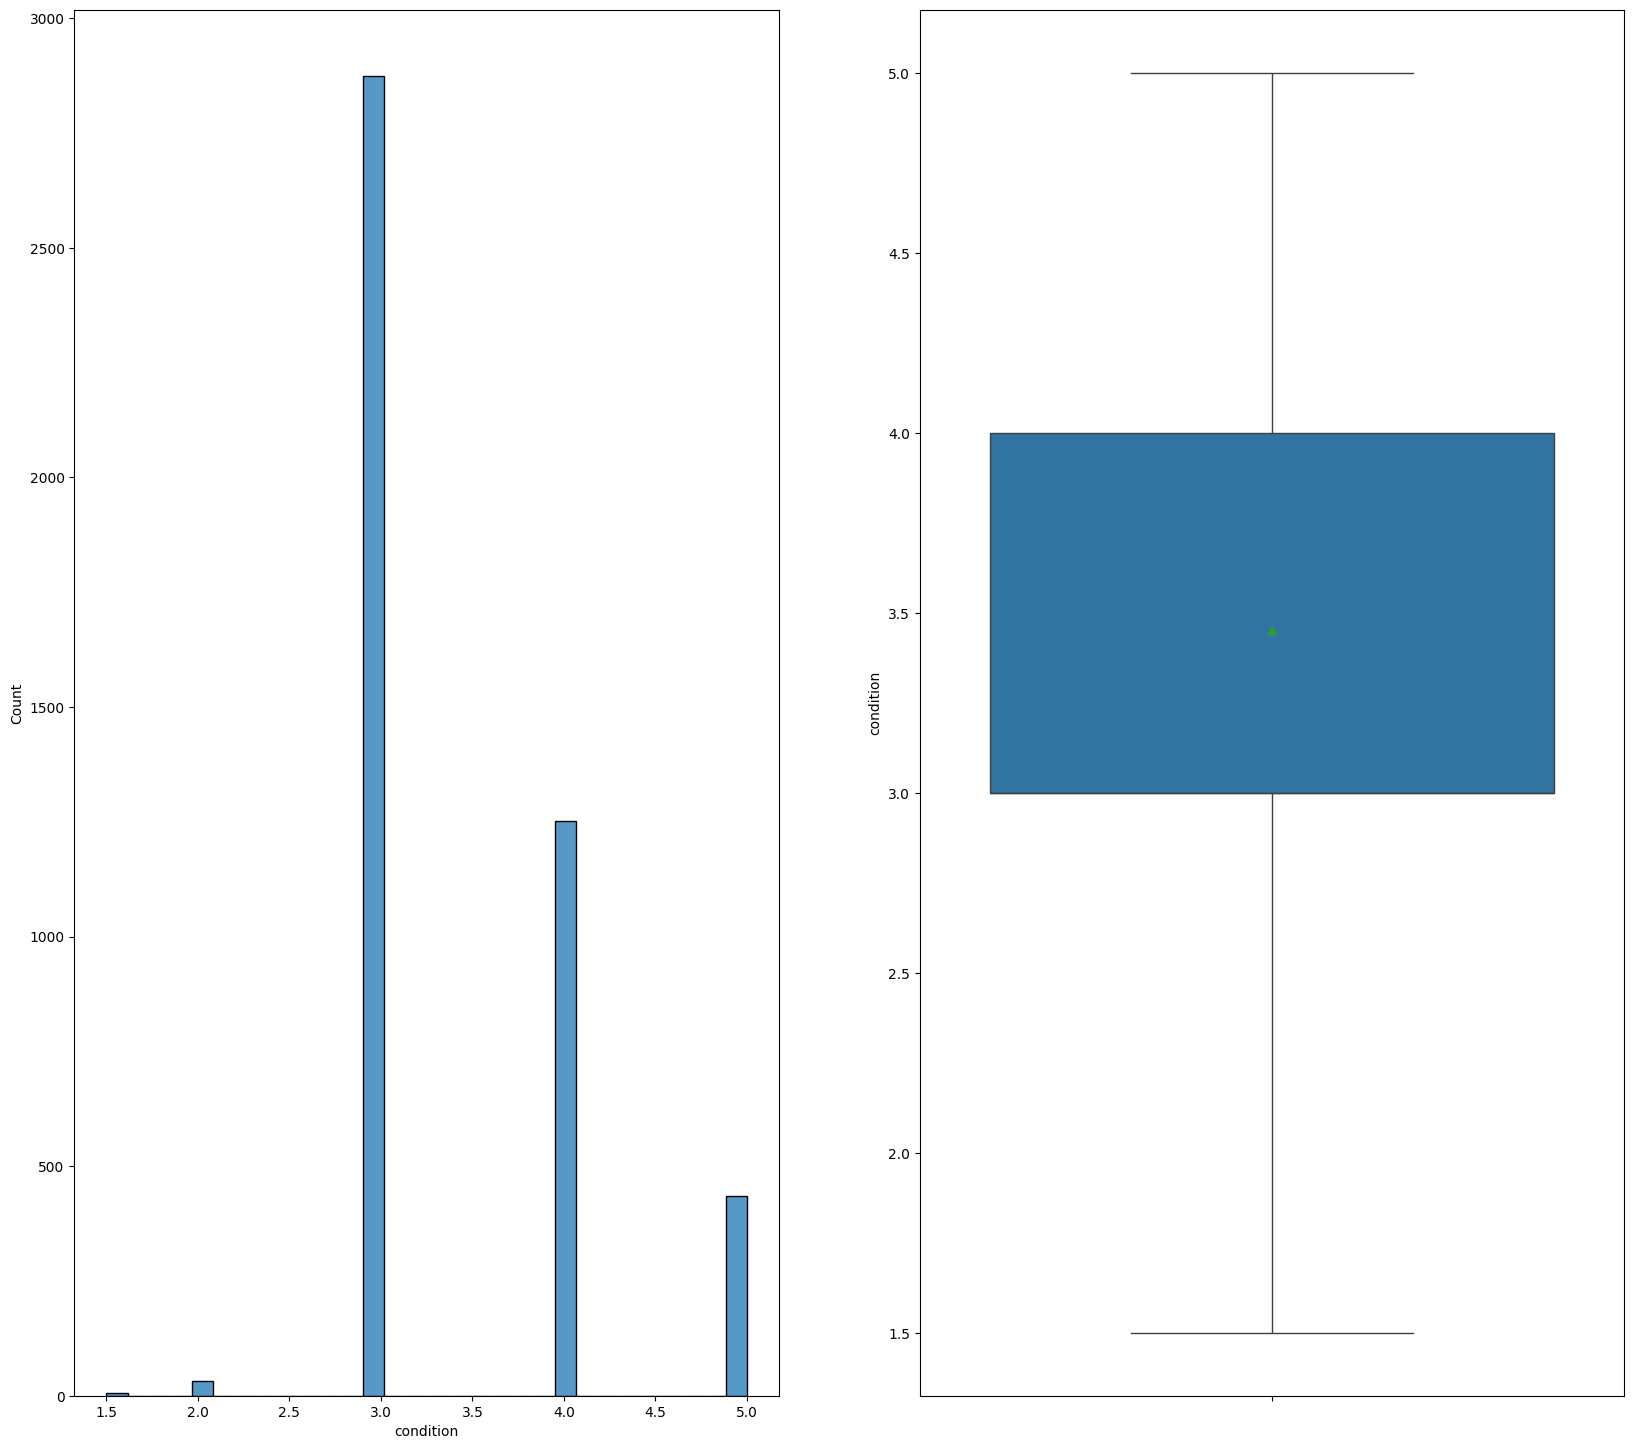

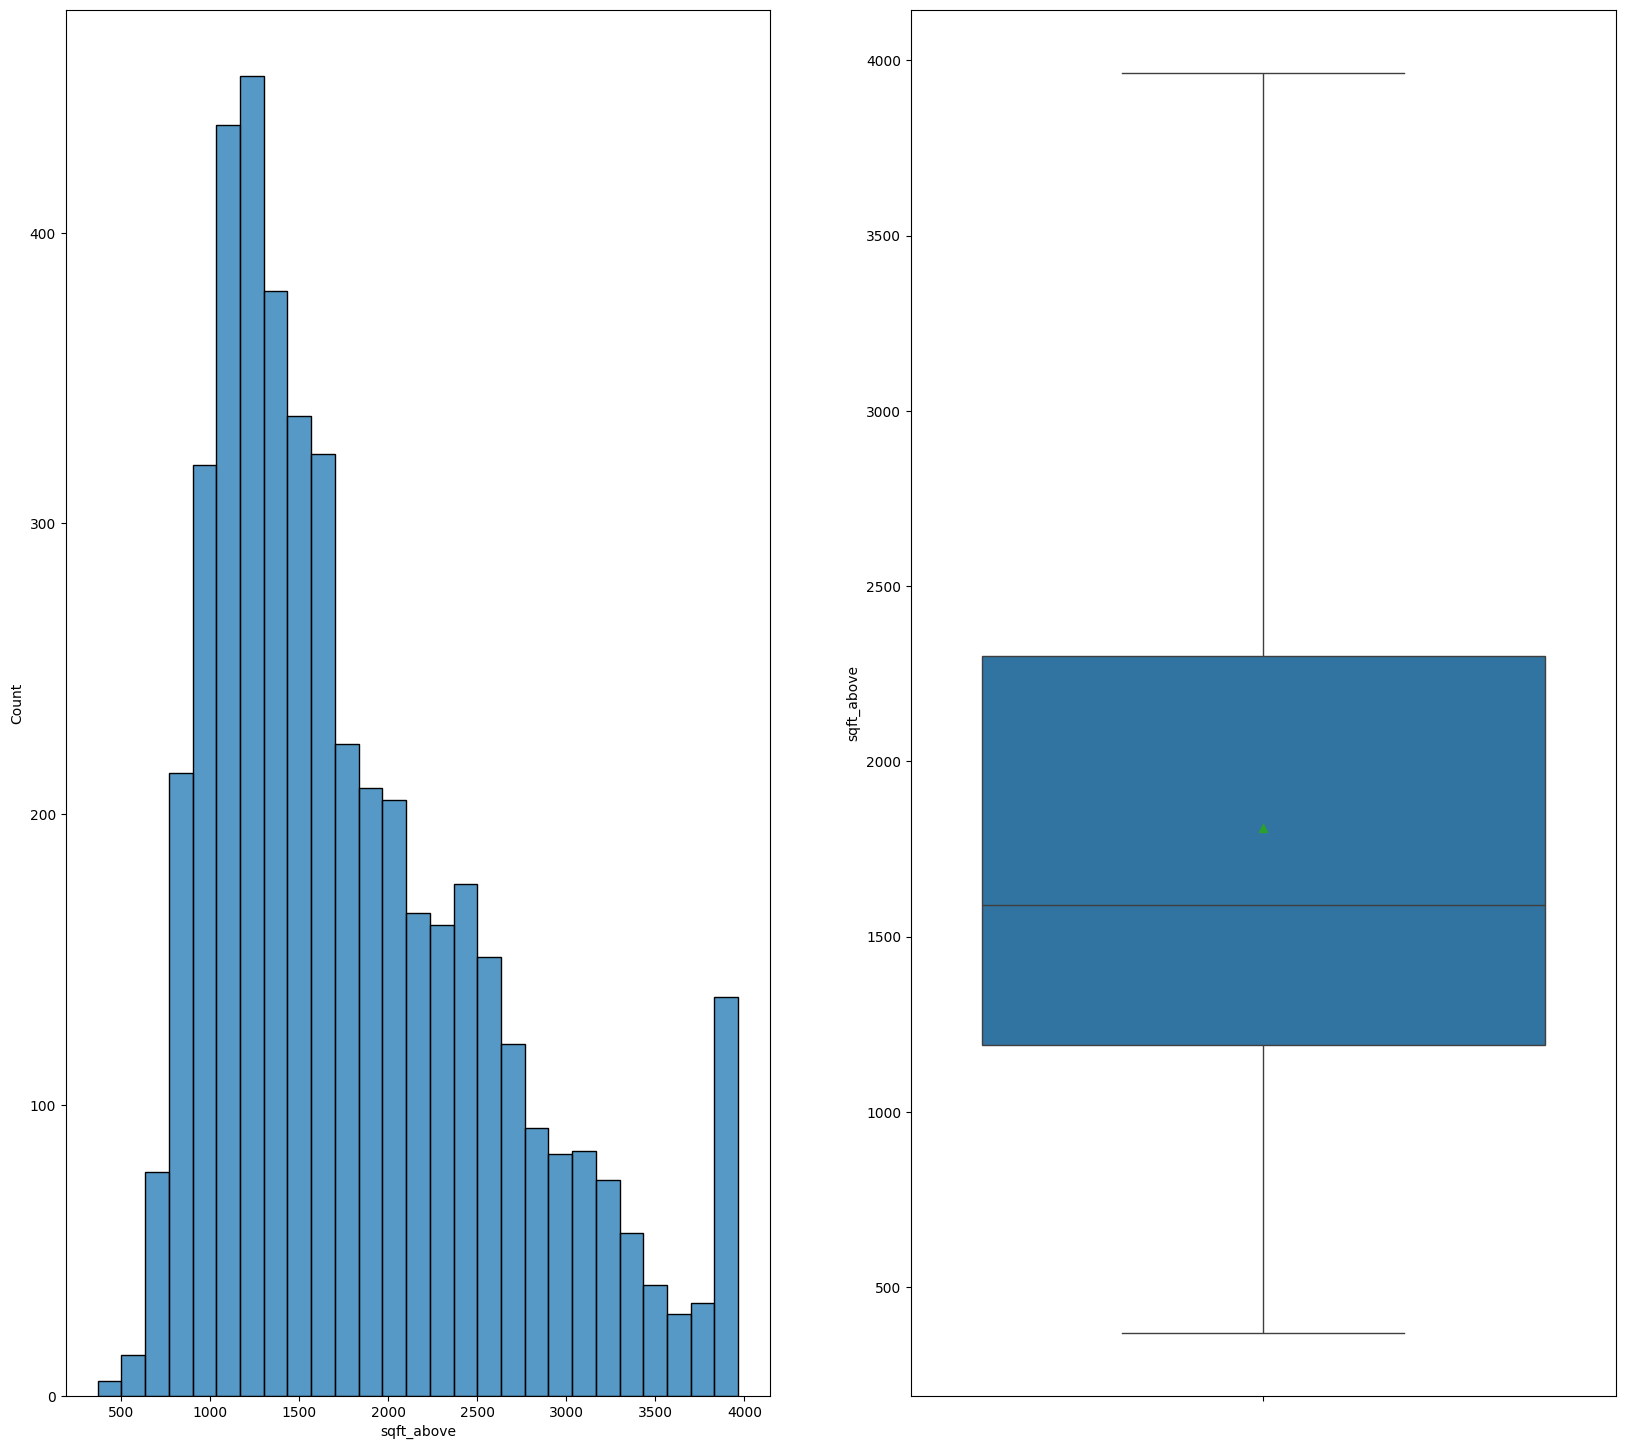

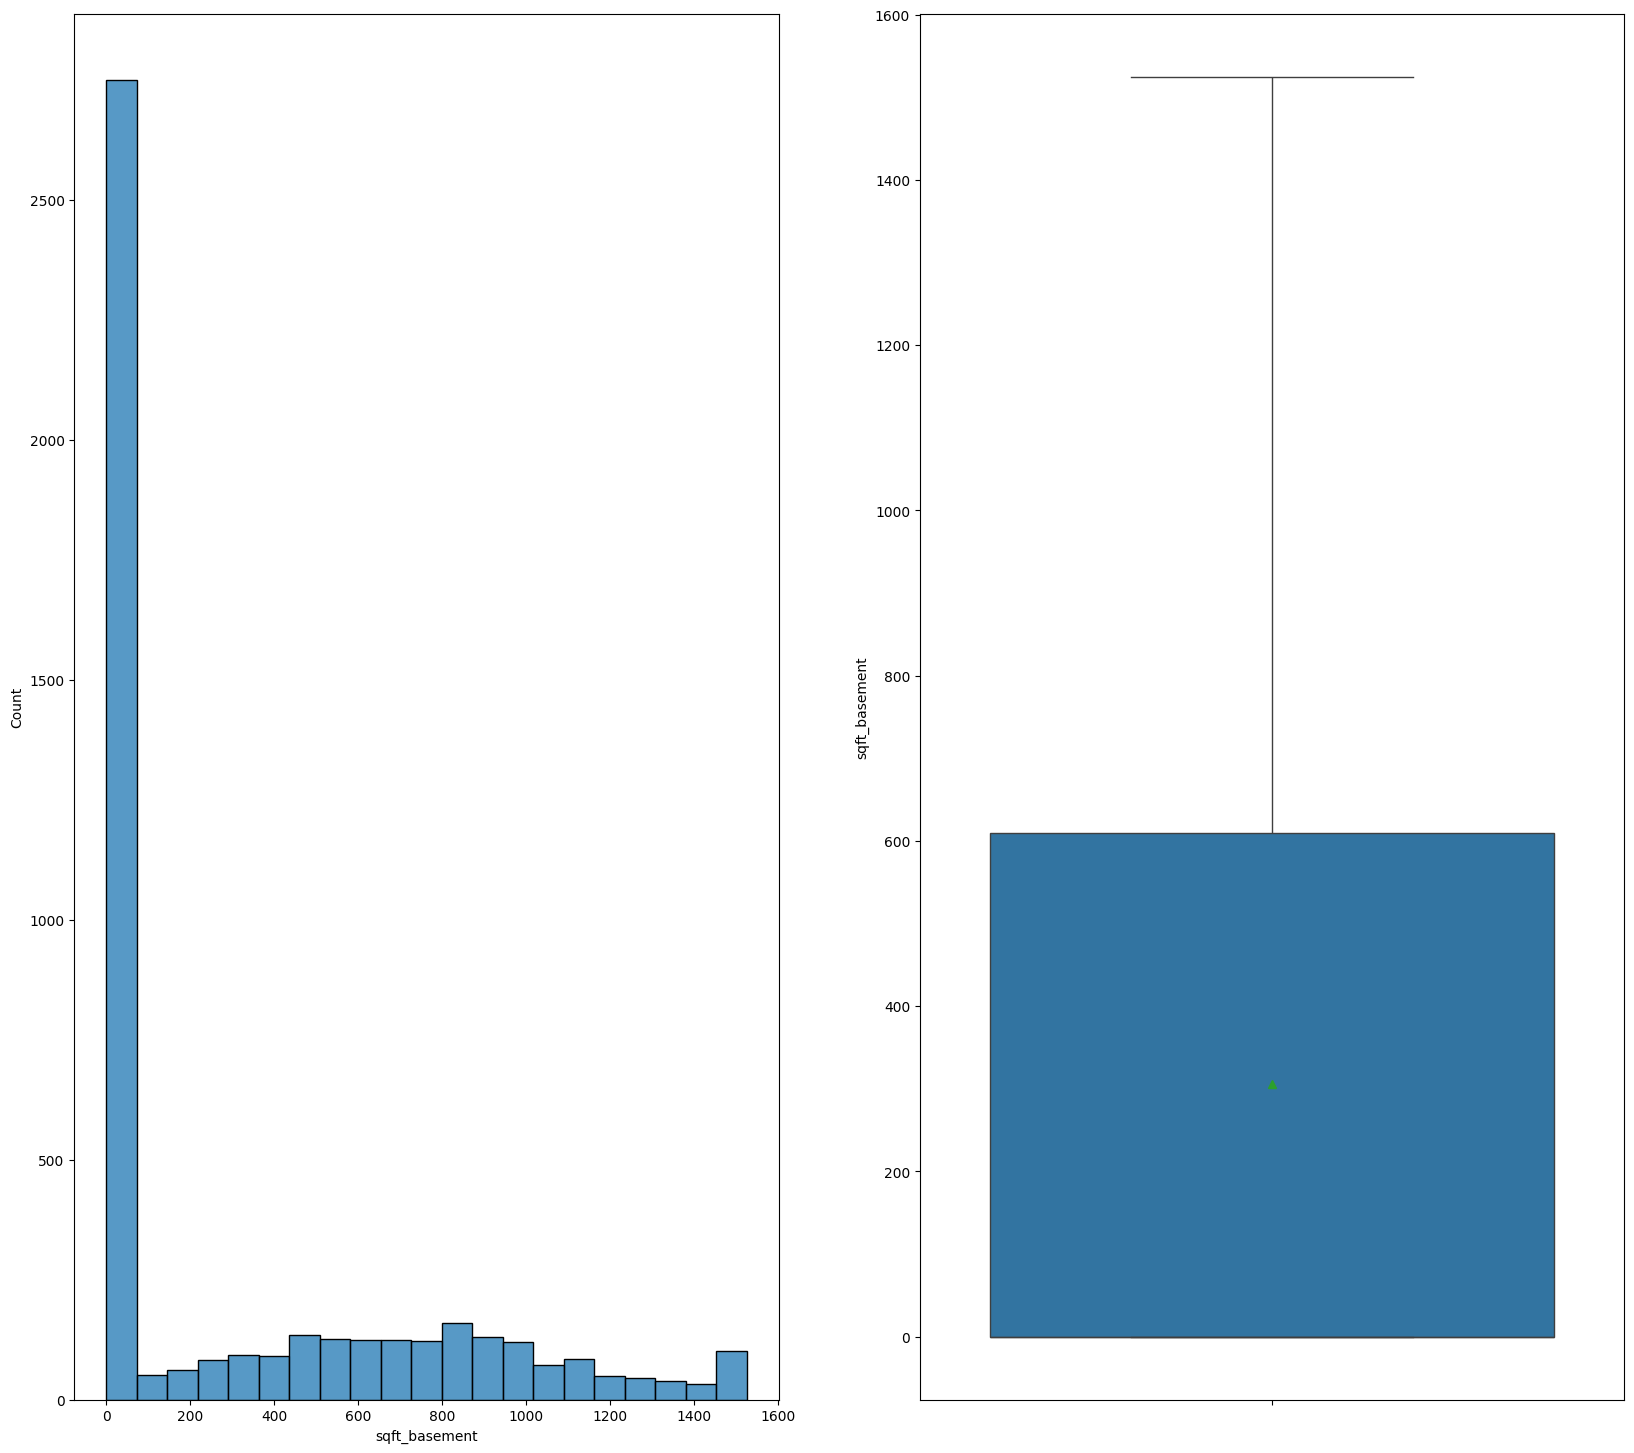

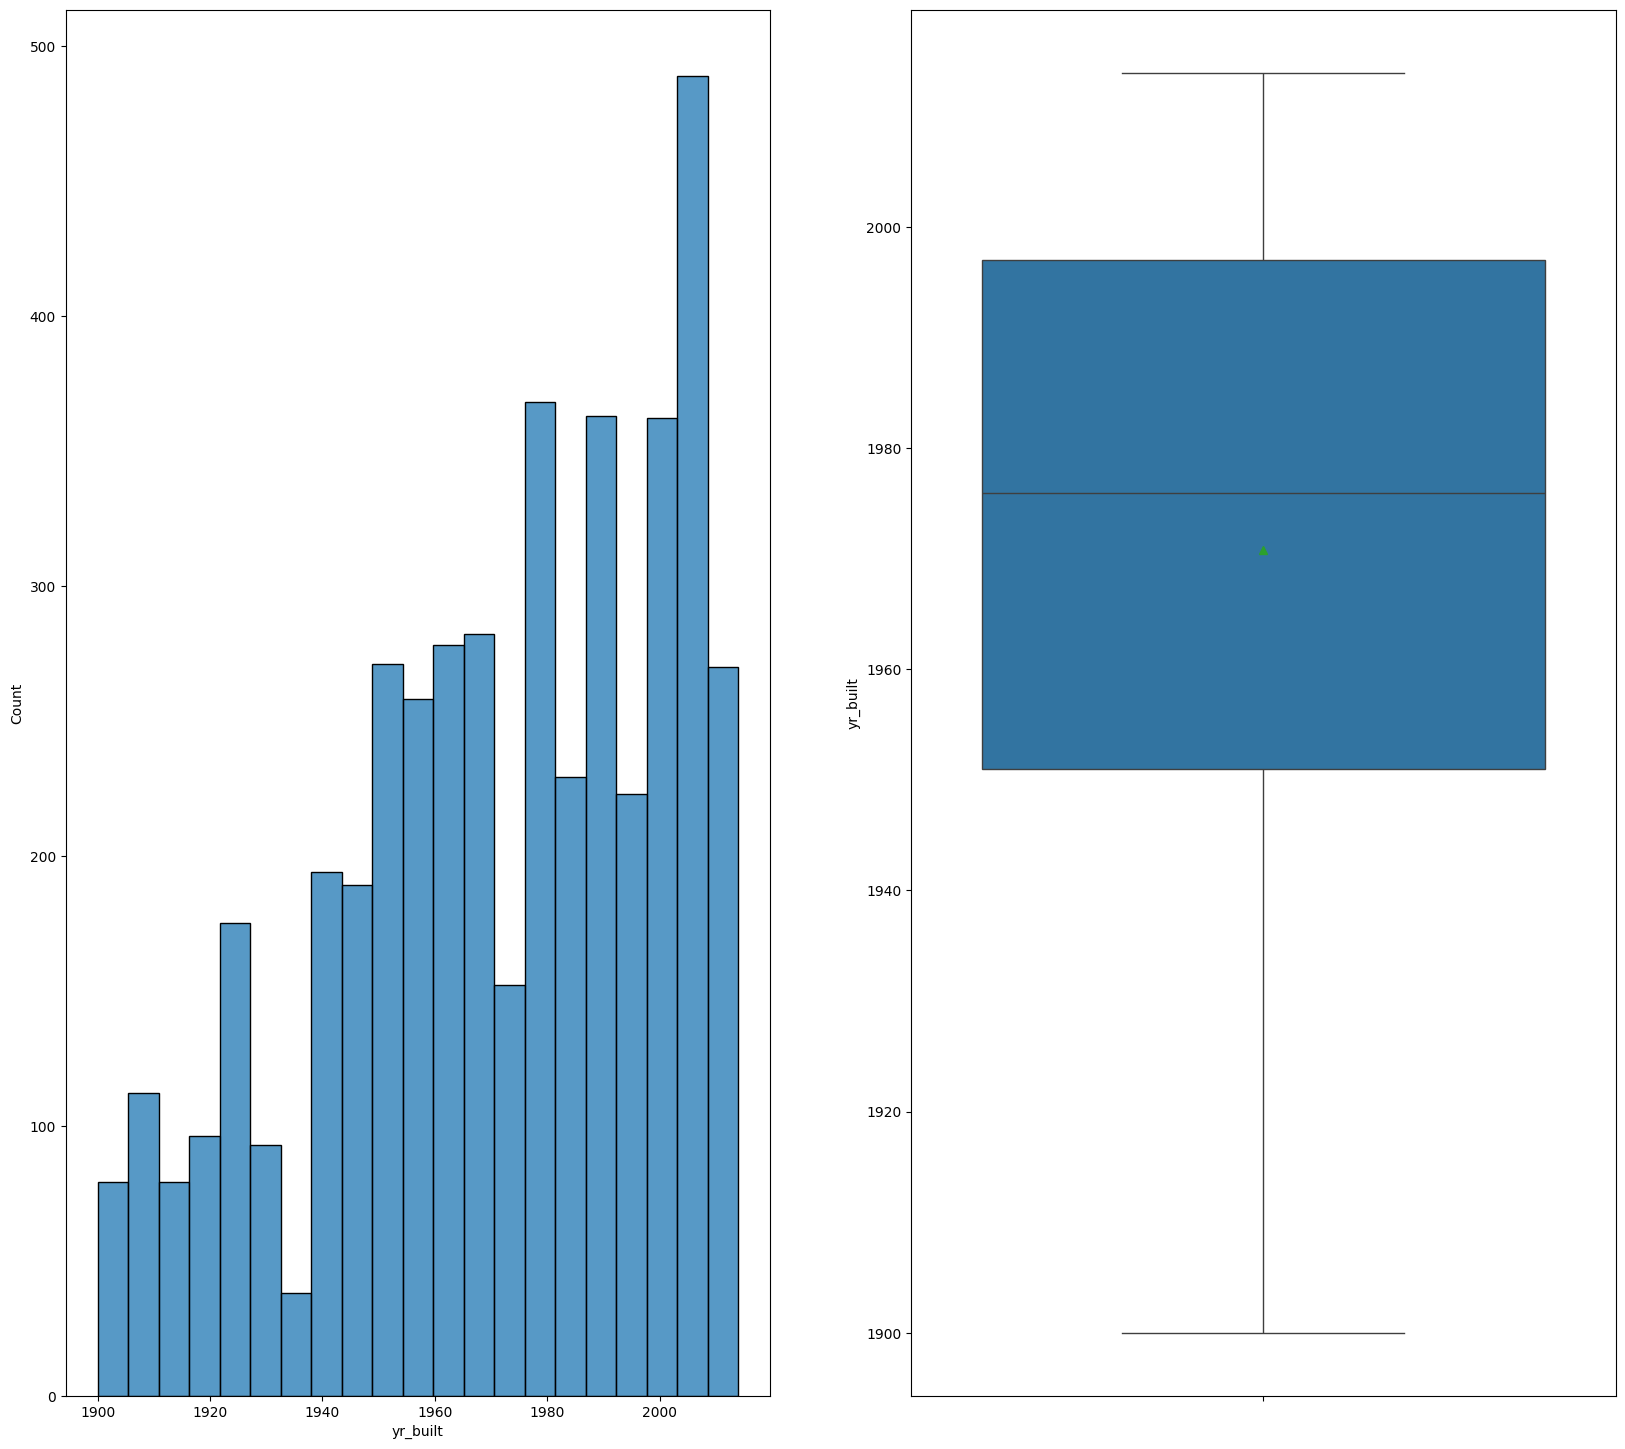

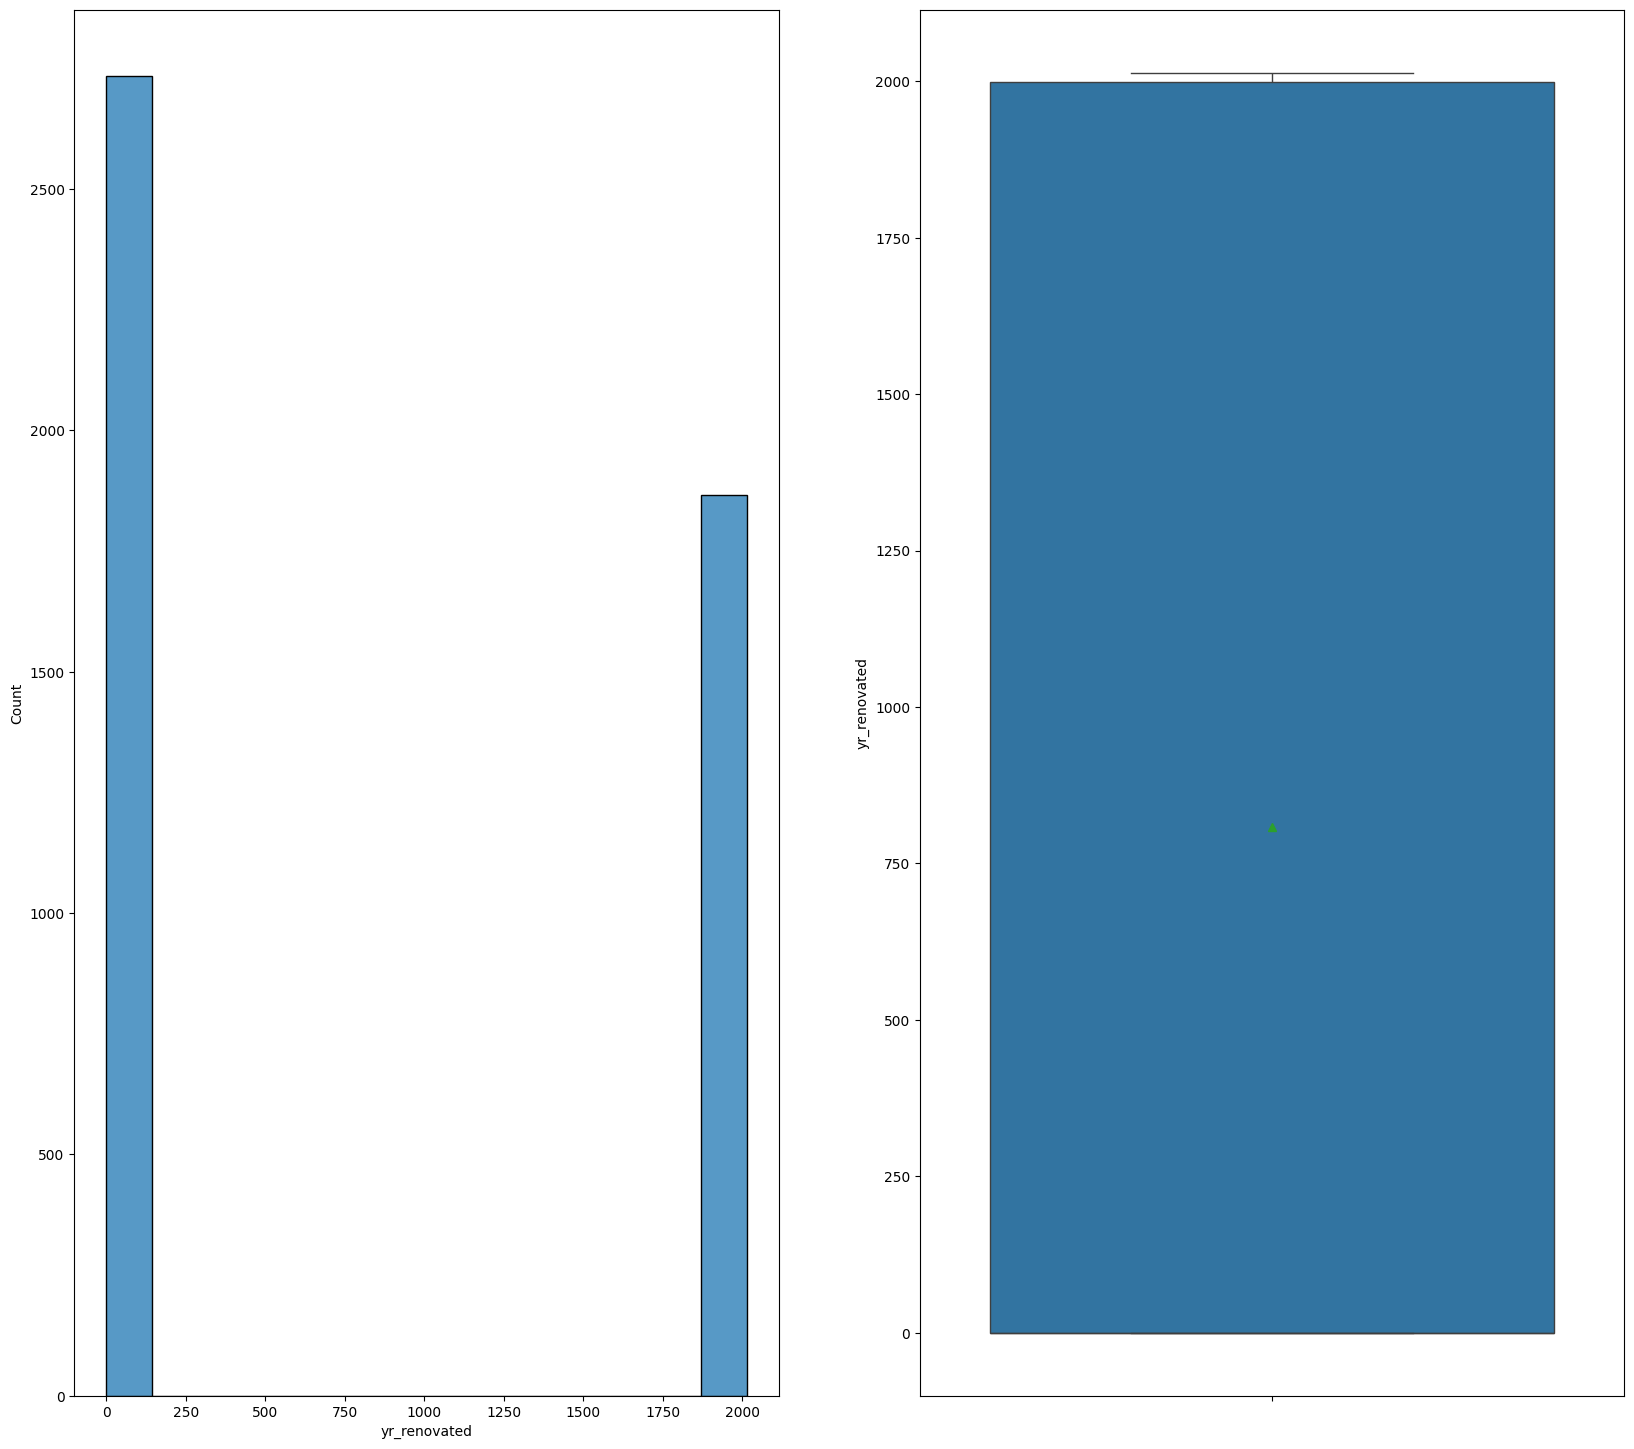

In [77]:
for col in df.select_dtypes('number').columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
    sns.histplot(df[col], ax = axes[0])
    sns.boxplot(df[col], ax = axes[1], showmeans=True)
plt.show() 

In [81]:
class DataPreprocessor:
    """
    Prétraitement des Données

    • Nettoyage : Imputer les valeurs manquantes.
    • Encodage des variables catégorielles : Appliquer l’encodage par variables factices (dummy variables)
      pour les données non numériques.
    • Standardisation : Standardiser les données numériques pour améliorer les performances des algorithmes.
    • Livrable : Code et documentation du pipeline de prétraitement des données.
    Attributes:
    -----------
    df : pd.DataFrame
        Le DataFrame contenant les données à traiter.
    target_column : str
        La colonne cible pour le modèle.
    exclude_columns : list
        Les colonnes à exclure du prétraitement (par défaut, aucune colonne n'est exclue).
    test_size : float
        La proportion de l'ensemble de test (par défaut, 0.2).
    random_state : int
        Graine aléatoire pour la reproductibilité du découpage en train/test (par défaut, 0).
    """
    
    def __init__(self, df: pd.DataFrame, target_column: str, exclude_columns=None, test_size: float = 0.2, random_state: int = 0):
        
        self.df = df
        self.target_column = target_column
        self.exclude_columns = exclude_columns if exclude_columns is not None else []
        self.test_size = test_size
        self.random_state = random_state
        


    def split_data(self) -> list:
        """
        Divise les données en ensembles d'entraînement et de test.

        Returns:
        --------
        X_train, X_test, y_train, y_test : tuple
            Données divisées en ensembles d'entraînement et de test.
        """
        y = self.df[self.target_column]
        X = self.df.drop([self.target_column] + self.exclude_columns, axis='columns')
        
        X_train, X_test, y_train, y_test = train_test_split(
                                 X, 
                                 y, 
                                 test_size=self.test_size, 
                                 random_state=self.random_state
                            )
        return X_train, X_test, y_train, y_test
        

    def create_pipeline(self, X_train):
        """
        Crée un pipeline de prétraitement pour les données.

        Étapes du pipeline :
        - Imputation des valeurs manquantes.
        - Standardisation des colonnes numériques.
        - Encodage des variables catégorielles avec des variables factices.

        Parameters:
        -----------
        X_train : pd.DataFrame
            Données d'entraînement pour déterminer les types de colonnes.
   Returns:
        --------
        full_pipeline : ColumnTransformer
            Pipeline de transformations pour le prétraitement complet des données.
        """
        num_cols = X_train.select_dtypes(include=['number']).columns
        cat_cols = X_train.select_dtypes(include='object').columns
        num_pipeline = make_pipeline(
                    StandardScaler(),
                )
        cat_pipeline = make_pipeline(
                    OneHotEncoder(handle_unknown='ignore', drop='first')
                )
        full_pipeline = make_column_transformer(
                (num_pipeline, num_cols),
                (cat_pipeline, cat_cols),
            )
        return full_pipeline


In [82]:
preprocessing = DataPreprocessor(df, 'price', ['date', 'country'],random_state=10)
X_train, X_test, y_train, y_test = preprocessing.split_data()
pipeline = preprocessing.create_pipeline(X_train)

In [83]:
X_train_transform = pipeline.fit_transform(X_train)
X_test_transform = pipeline.transform(X_test)

c:\Users\ariel\Downloads\cours MLOPS\Projet Mlops\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 4. Modélisation et Prédiction

### - Modele Regression lineaire

In [84]:
model_lr = LinearRegression(tol = 1e-06)
model_lr.fit(X_train_transform, y_train)
y_pred_lr = model_lr.predict(X_test_transform)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = mse ** 0.5
print(f"Resultats:")
print(f"  RMSE: {rmse:.2f}")

Resultats:
  RMSE: 176079.55


### - Modele Lightgbm

In [87]:
model_lgbm = LGBMRegressor(n_estimators = 100, random_state= 10, verbosity = 0)
model_lgbm.fit(X_train_transform, y_train)
y_pred_lgbm = model_lgbm.predict(X_test_transform)
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = mse ** 0.5
print(f"Resultats:")
print(f"  RMSE: {rmse:.2f}")

Resultats:
  RMSE: 142201.72


c:\Users\ariel\Downloads\cours MLOPS\Projet Mlops\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


###  5. Évaluation et Optimisation des Modèles

## Affichons les parametres pour les modeles pour rechercher les hyperparametres pour optimiser les models

In [ ]:
print(model_lr.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [ ]:
print(model_lgbm.get_params())

{'priors': None, 'var_smoothing': 1e-09}


### -Utiliser le cross validation pour évaluer les modèles et éviter le surapprentissage.

In [72]:
scores_knn = cross_val_score(model_knn, X_train_reduce, y_train, cv=5, scoring='accuracy')
print(f"Scores de validation croisée: {scores_knn}")
print(f"Précision moyenne: {scores_knn.mean():.2f}")

Scores de validation croisée: [0.82681295 0.82700544 0.83071075 0.83051826 0.82959577]
Précision moyenne: 0.83


In [73]:
scores_nb = cross_val_score(model_NB, X_train_reduce, y_train, cv=5, scoring='accuracy')
print(f"Scores de validation croisée: {scores_nb}")
print(f"Précision moyenne: {scores_nb.mean():.2f}")

Scores de validation croisée: [0.76252346 0.77662288 0.76574756 0.76954911 0.77285852]
Précision moyenne: 0.77


### -Utiliser le GridSearch cv pour optimiser les hyper parametres du KNN.

In [74]:
param_grid = {'n_neighbors': range(1, 20), 'metric': ['minkowski','euclidean', 'manhattan'], 'weights': ['uniform','distance']}

grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_reduce, y_train)

print("Meilleurs hyper-paramètres:", grid_search.best_params_)
print(f"Meilleure performance: {grid_search.best_score_:.3f}")

C:\Users\ariel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs hyper-paramètres: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Meilleure performance: 0.838


## Modelisons un nouveau KNN avec les nouveaux hyper parametres

In [82]:
model_knn_opt = KNeighborsClassifier(n_neighbors=18, metric='manhattan', weights='distance')
model_knn_opt.fit(X_train_reduce, y_train)
y_pred_knn_opt = model_knn_opt.predict(X_test_reduce)
rapport_KNN_opt = classification_report(y_test, y_pred_knn_opt)
print(rapport_KNN_opt)

              precision    recall  f1-score   support

dissatisfied       0.83      0.83      0.83     11864
   satisfied       0.86      0.85      0.85     14112

    accuracy                           0.84     25976
   macro avg       0.84      0.84      0.84     25976
weighted avg       0.84      0.84      0.84     25976



## Tableau recapitulatif des performances entre le modele Knn et sa version Optimisee

In [91]:
rapport_KNN = classification_report(y_test, y_pred_knn, output_dict=True)
rapport_KNN_opt = classification_report(y_test, y_pred_knn_opt, output_dict=True)

performance_summary = pd.DataFrame({
    'Modèle': ['KNN', 'KNN Optimisé'],
    'Précision': [rapport_KNN['accuracy'], rapport_KNN_opt['accuracy']],
    'Précision (macro)': [rapport_KNN['macro avg']['precision'], rapport_KNN_opt['macro avg']['precision']],
    'Rappel (macro)': [rapport_KNN['macro avg']['recall'], rapport_KNN_opt['macro avg']['recall']],
    'F1-score (macro)': [rapport_KNN['macro avg']['f1-score'], rapport_KNN_opt['macro avg']['f1-score']]
})
print(performance_summary)

         Modèle  Précision  Précision (macro)  Rappel (macro)  \
0           KNN   0.832153           0.830863        0.830960   
1  KNN Optimisé   0.842739           0.841474        0.841798   

   F1-score (macro)  
0          0.830911  
1          0.841629  


Nous remarquons ainsi une legere amelioration entre le modele du KNN avant l'optmisation et apres l'optimisation.
Bien que cela ne fasse pas une tres grande difference a premiere vue d'oeil, il pourrait y avoir encore d'autres hyper-parametres a ajouter et a preciser avec plus analyse.